<a href="https://colab.research.google.com/github/RedaAllouche/essaies-/blob/main/tp_anad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# Chargez votre fichier
import pandas as pd
df = pd.read_csv('crossa.wheat.csv')  # Remplacez par le nom de votre fichier
df.head()
!pip install prince
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go

In [81]:
df.describe()

,rownames,yield
count,450.000000,450.000000
mean,225.500000,4.653778
std,130.048068,2.369103
min,1.000000,0.700000
25%,113.250000,2.800000
50%,225.500000,4.400000
75%,337.750000,6.100000
max,450.000000,12.500000


In [82]:
df['yield_cat'] = pd.cut(df['yield'],
                          bins=3,
                          labels=['Faible', 'Moyen', 'Élevé'])

In [83]:
df.describe()

,rownames,yield
count,450.000000,450.000000
mean,225.500000,4.653778
std,130.048068,2.369103
min,1.000000,0.700000
25%,113.250000,2.800000
50%,225.500000,4.400000
75%,337.750000,6.100000
max,450.000000,12.500000


In [84]:
# Remplacez cette ligne dans le code :
variables_qualitatives = ['loc', 'locgroup', 'gen', 'gengroup','yield_cat']
donnees = df[variables_qualitatives].dropna()

In [85]:
donnees.head()

,loc,locgroup,gen,gengroup,yield_cat
0,AK,Grp2,G01,W2,Moyen
1,AS,Grp1,G01,W2,Faible
2,BJ,Grp1,G01,W2,Faible
3,CA,Grp2,G01,W2,Faible
4,EB,Grp2,G01,W2,Moyen


In [86]:
donnees.describe()

,loc,locgroup,gen,gengroup,yield_cat
count,450,450,450,450,450
unique,25,2,18,3,3
top,AK,Grp1,G01,W2,Faible
freq,18,288,25,225,237


In [87]:
print("\nDistribution des catégories :")
print(df['yield_cat'].value_counts())


Distribution des catégories :
yield_cat
Faible    237
Moyen     189
Élevé      24
Name: count, dtype: int64


In [92]:
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())


--- rownames ---
rownames
450    1
1      1
434    1
433    1
432    1
      ..
7      1
6      1
5      1
4      1
3      1
Name: count, Length: 450, dtype: int64

--- loc ---
loc
AK    18
AS    18
BJ    18
CA    18
EB    18
EG    18
ES    18
ID    18
IL    18
JM    18
KN    18
MG    18
MM    18
MS    18
NB    18
PA    18
PI    18
SC    18
SE    18
SG    18
SJ    18
SR    18
SS    18
TB    18
TC    18
Name: count, dtype: int64

--- locgroup ---
locgroup
Grp1    288
Grp2    162
Name: count, dtype: int64

--- gen ---
gen
G01    25
G02    25
G03    25
G04    25
G05    25
G06    25
G07    25
G08    25
G09    25
G10    25
G11    25
G12    25
G13    25
G14    25
G15    25
G16    25
G17    25
G18    25
Name: count, dtype: int64

--- gengroup ---
gengroup
W2    225
W3    125
W1    100
Name: count, dtype: int64

--- yield ---
yield
3.9     16
5.5     15
3.5     11
2.1     11
2.0      9
        ..
9.9      1
9.4      1
11.2     1
8.5      1
10.7     1
Name: count, Length: 90, dtype: int64

---

ACM standard :

In [88]:
mca = prince.MCA(
    n_components=46,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

# Ajustement du modèle
mca = mca.fit(donnees)

print("\n=== ACM STANDARD ===")
print("Valeurs propres (eigenvalues) :")
eigenvalues_standard = mca.eigenvalues_
eigenvalues_standard = eigenvalues_standard[eigenvalues_standard > 1 / len(variables_qualitatives)]
print(eigenvalues_standard)

print("\nPourcentage de variance expliquée :")
variance_explained = (eigenvalues_standard / eigenvalues_standard.sum() * 100)
print(variance_explained)

print("\nCumul de variance expliquée :")
cumul_variance = np.cumsum(variance_explained)
print(cumul_variance)


=== ACM STANDARD ===
Valeurs propres (eigenvalues) :
[0.45655475 0.40066095 0.4        0.37986619 0.3230701  0.2
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2        0.2       ]

Pourcentage de variance expliquée :
[12.14192267 10.6554456  10.63786787 10.10241597  8.59194246  5.31893394
  5.31893394  5.31893394  5.31893394  5.31893394  5.31893394  5.31893394
  5.31893394  5.31893394]

Cumul de variance expliquée :
[ 12.14192267  22.79736827  33.43523614  43.53765211  52.12959457
  57.44852851  62.76746244  68.08639638  73.40533032  78.72426425
  84.04319819  89.36213213  94.68106606 100.        ]


Correction de Benzecri

In [89]:
# =====================================================
# 3. CORRECTION DE BENZÉCRI
# =====================================================

def correction_benzecri(eigenvalues, K):
    """
    Applique la correction de Benzécri aux valeurs propres

    Formule: λ_ajusté = ((K/(K-1)) * (√λ - 1/K))²
    où K = nombre de variables actives
    """
    lambda_benzecri = []

    for lam in eigenvalues:
        if lam > 1/K:
            corrected = ((K/(K-1)) * (np.sqrt(lam) - 1/K))**2
            lambda_benzecri.append(corrected)
        else:
            lambda_benzecri.append(0)

    return np.array(lambda_benzecri)

K = len(variables_qualitatives)
lambda_benzecri = correction_benzecri(eigenvalues_standard, K)

# Calcul des pourcentages
inertie_totale_benzecri = lambda_benzecri.sum()
print("Inertie totale de Benzecri : ",inertie_totale_benzecri)
pourcentage_benzecri = (lambda_benzecri / inertie_totale_benzecri) * 100
cumul_benzecri = np.cumsum(pourcentage_benzecri)

benzecri_df = pd.DataFrame({
    'Dimension': range(1, len(lambda_benzecri) + 1),
    'Valeur_propre_corrigee': lambda_benzecri,
    'Pourcentage_variance': pourcentage_benzecri,
    'Cumul': cumul_benzecri
})

print("\n=== CORRECTION DE BENZÉCRI ===")
print(benzecri_df)

Inertie totale de Benzecri :  2.2810065402751074

=== CORRECTION DE BENZÉCRI ===
    Dimension  Valeur_propre_corrigee  Pourcentage_variance       Cumul
0           1                0.353562             15.500244   15.500244
1           2                0.292922             12.841769   28.342012
2           3                0.292215             12.810805   41.152817
3           4                0.270833             11.873394   53.026211
4           5                0.212052              9.296408   62.322619
5           6                0.095492              4.186376   66.508995
6           7                0.095492              4.186376   70.695370
7           8                0.095492              4.186376   74.881746
8           9                0.095492              4.186376   79.068122
9          10                0.095492              4.186376   83.254497
10         11                0.095492              4.186376   87.440873
11         12                0.095492              4.18

Correction de Greenacre

In [90]:
# =====================================================
# 4. CORRECTION DE GREENACRE
# =====================================================

def correction_greenacre(eigenvalues, K, J, n):
    """
    Applique la correction de Greenacre aux valeurs propres

    J = nombre total de modalités
    K = nombre de variables
    n = nombre d'observations
    """
    # Inertie moyenne attendue sous hypothèse d'indépendance
    inertie_moyenne = (J - K) / (n * K)

    # Correction
    lambda_greenacre = eigenvalues - inertie_moyenne
    lambda_greenacre[lambda_greenacre < 0] = 0

    return lambda_greenacre

# Calcul du nombre de modalités par variable
nb_modalites = [donnees[col].nunique() for col in variables_qualitatives]
J = sum(nb_modalites)
n = len(donnees)

lambda_greenacre = correction_greenacre(eigenvalues_standard, K, J, n)

# Calcul des pourcentages
inertie_totale_greenacre = lambda_greenacre.sum()
pourcentage_greenacre = (lambda_greenacre / inertie_totale_greenacre) * 100
cumul_greenacre = np.cumsum(pourcentage_greenacre)

greenacre_df = pd.DataFrame({
    'Dimension': range(1, len(lambda_greenacre) + 1),
    'Valeur_propre_corrigee': lambda_greenacre,
    'Pourcentage_variance': pourcentage_greenacre,
    'Cumul': cumul_greenacre
})

print("\n=== CORRECTION DE GREENACRE ===")
print(greenacre_df)


=== CORRECTION DE GREENACRE ===
    Dimension  Valeur_propre_corrigee  Pourcentage_variance       Cumul
0           1                0.436110             12.553803   12.553803
1           2                0.380217             10.944853   23.498656
2           3                0.379556             10.925827   34.424483
3           4                0.359422             10.346258   44.770741
4           5                0.302626              8.711335   53.482076
5           6                0.179556              5.168658   58.650734
6           7                0.179556              5.168658   63.819393
7           8                0.179556              5.168658   68.988051
8           9                0.179556              5.168658   74.156709
9          10                0.179556              5.168658   79.325367
10         11                0.179556              5.168658   84.494025
11         12                0.179556              5.168658   89.662684
12         13                0.

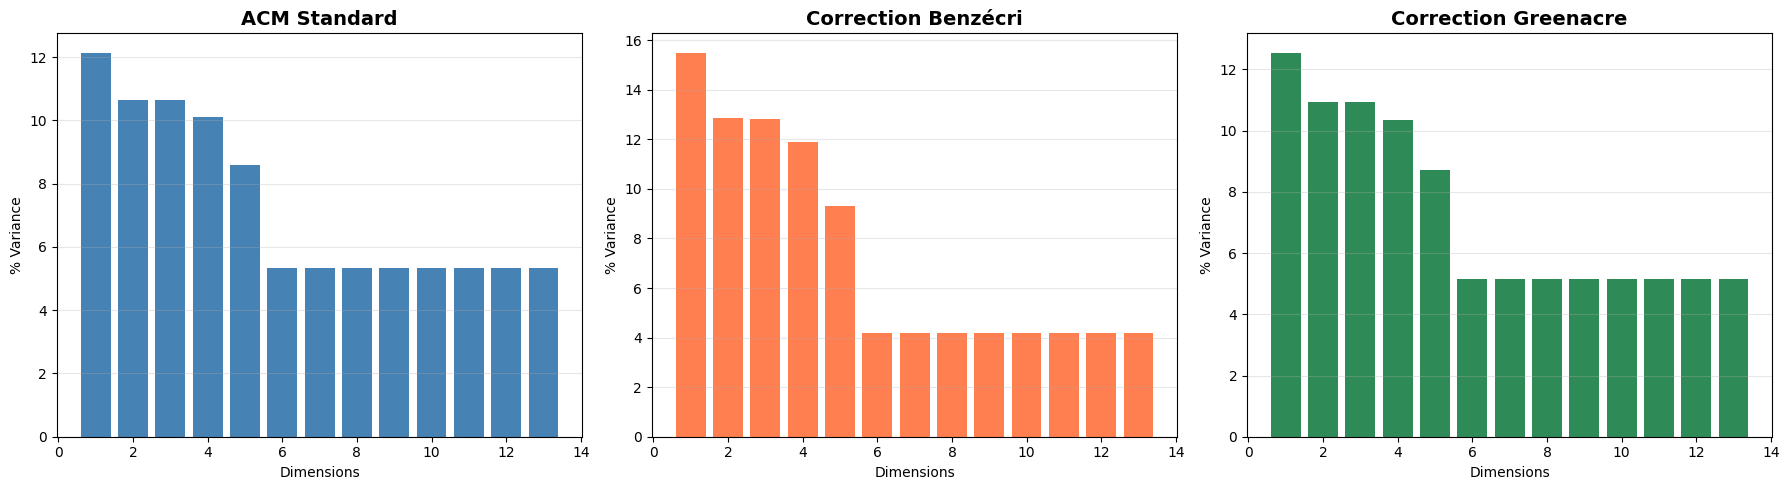

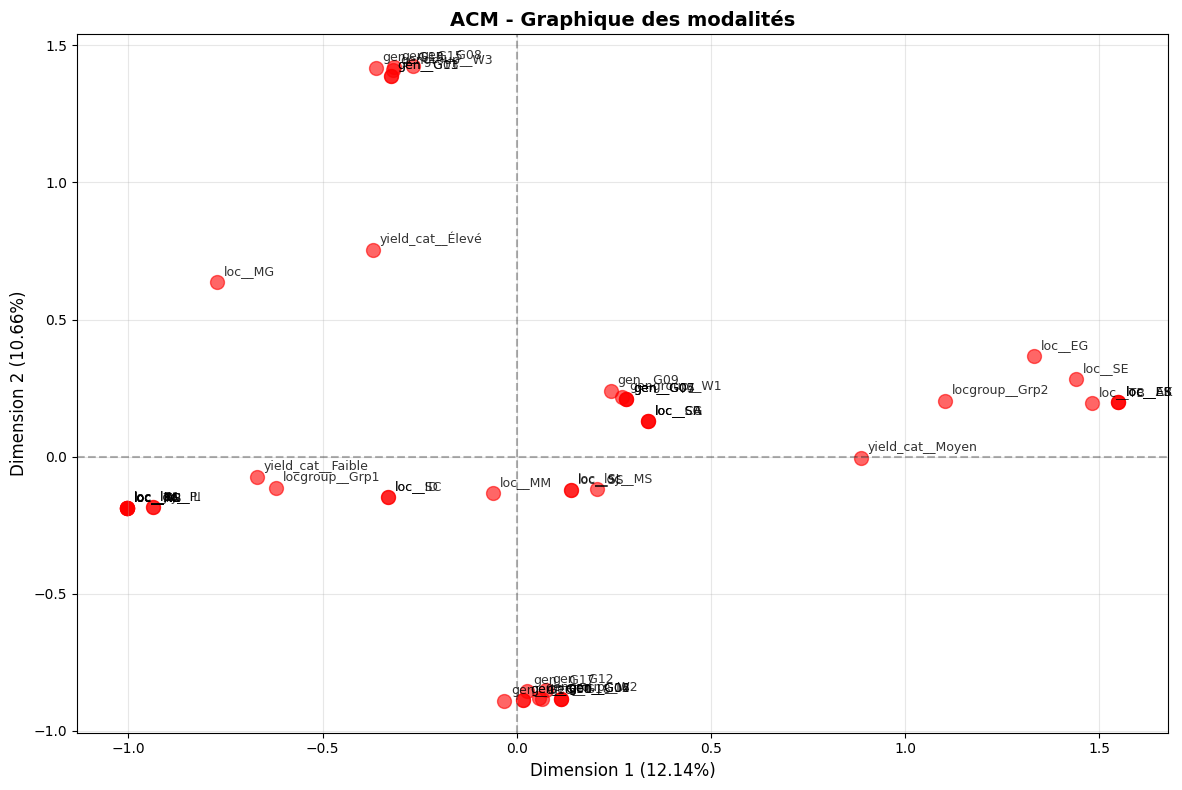

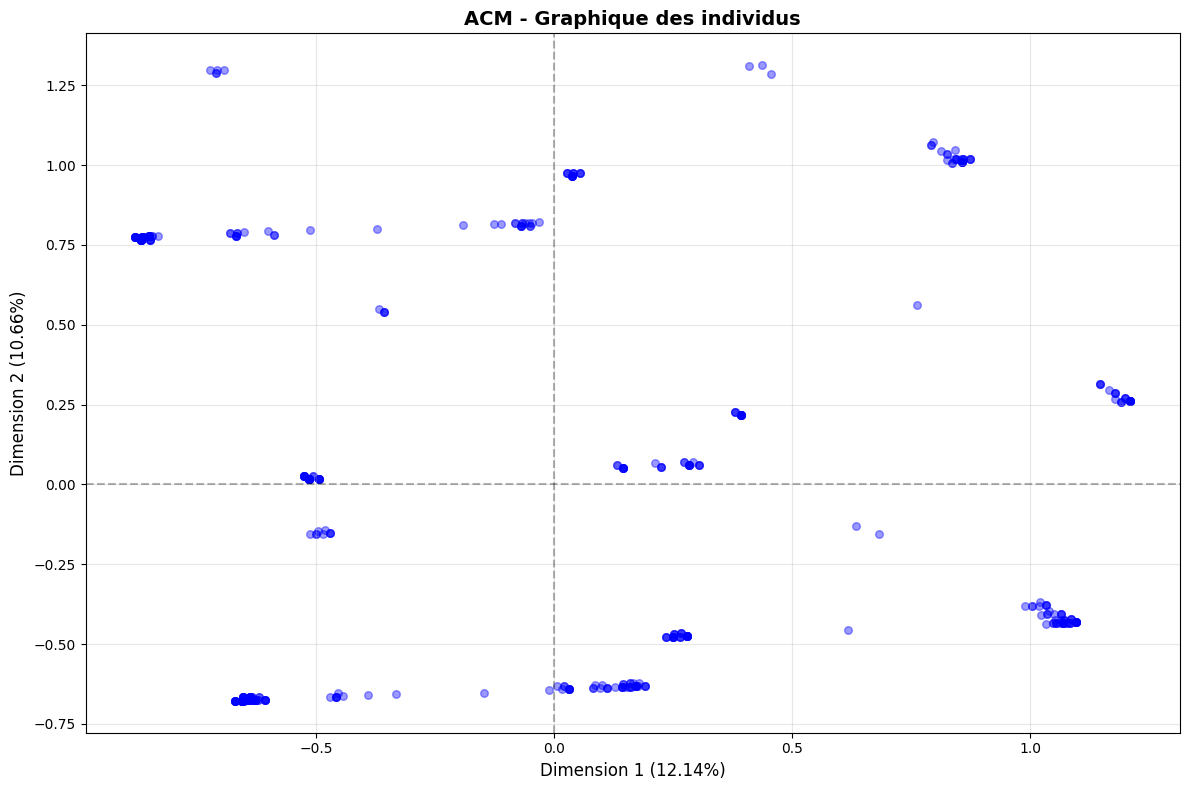


=== TABLEAU RÉCAPITULATIF ===
   Dimension  Standard (%)  Benzécri (%)  Greenacre (%)
0          1         12.14         15.50          12.55
1          2         10.66         12.84          10.94
2          3         10.64         12.81          10.93
3          4         10.10         11.87          10.35
4          5          8.59          9.30           8.71

✅ Analyse terminée ! Tous les graphiques ont été générés.


In [94]:


# =====================================================
# 5. VISUALISATIONS COMPARATIVES
# =====================================================

# Graphique comparatif des valeurs propres
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Standard
axes[0].bar(range(1, 14), variance_explained[:13], color='steelblue')
axes[0].set_title('ACM Standard', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dimensions')
axes[0].set_ylabel('% Variance')
axes[0].grid(axis='y', alpha=0.3)

# Benzécri
axes[1].bar(range(1, 14), pourcentage_benzecri[:13], color='coral')
axes[1].set_title('Correction Benzécri', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dimensions')
axes[1].set_ylabel('% Variance')
axes[1].grid(axis='y', alpha=0.3)

# Greenacre
axes[2].bar(range(1, 14), pourcentage_greenacre[:13], color='seagreen')
axes[2].set_title('Correction Greenacre', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Dimensions')
axes[2].set_ylabel('% Variance')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# =====================================================
# 6. GRAPHIQUE DES COORDONNÉES DES MODALITÉS
# =====================================================

# Obtenir les coordonnées des modalités (colonnes)
column_coords = mca.column_coordinates(donnees)

plt.figure(figsize=(12, 8))
plt.scatter(column_coords[0], column_coords[1], s=100, alpha=0.6, c='red')

# Ajouter les labels
for idx, label in enumerate(column_coords.index):
    plt.annotate(label,
                (column_coords.iloc[idx, 0], column_coords.iloc[idx, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                alpha=0.8)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel(f'Dimension 1 ({variance_explained[0]:.2f}%)', fontsize=12)
plt.ylabel(f'Dimension 2 ({variance_explained[1]:.2f}%)', fontsize=12)
plt.title('ACM - Graphique des modalités', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================
# 7. GRAPHIQUE DES INDIVIDUS
# =====================================================

# Obtenir les coordonnées des individus (lignes)
row_coords = mca.row_coordinates(donnees)

plt.figure(figsize=(12, 8))
plt.scatter(row_coords[0], row_coords[1], s=30, alpha=0.4, c='blue')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel(f'Dimension 1 ({variance_explained[0]:.2f}%)', fontsize=12)
plt.ylabel(f'Dimension 2 ({variance_explained[1]:.2f}%)', fontsize=12)
plt.title('ACM - Graphique des individus', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================
# 8. GRAPHIQUE INTERACTIF AVEC PLOTLY
# =====================================================

# Graphique interactif des modalités
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=column_coords[0],
    y=column_coords[1],
    mode='markers+text',
    text=column_coords.index,
    textposition='top center',
    marker=dict(size=12, color='red', opacity=0.7),
    name='Modalités'
))

fig.update_layout(
    title='ACM - Graphique interactif des modalités',
    xaxis_title=f'Dimension 1 ({variance_explained[0]:.2f}%)',
    yaxis_title=f'Dimension 2 ({variance_explained[1]:.2f}%)',
    hovermode='closest',
    width=900,
    height=700
)

fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

fig.show()

# =====================================================
# 9. TABLEAU RÉCAPITULATIF DES CORRECTIONS
# =====================================================

recap_df = pd.DataFrame({
    'Dimension': range(1, 6),
    'Standard (%)': variance_explained[:5].round(2),
    'Benzécri (%)': pourcentage_benzecri[:5].round(2),
    'Greenacre (%)': pourcentage_greenacre[:5].round(2)
})

print("\n=== TABLEAU RÉCAPITULATIF ===")
print(recap_df)

# =====================================================
# 10. FONCTION RÉUTILISABLE
# =====================================================

def acm_avec_corrections(data, variables, n_components=5):
    """
    Applique l'ACM avec les corrections de Benzécri et Greenacre

    Parameters:
    -----------
    data : DataFrame
        Le dataset complet
    variables : list
        Liste des noms de colonnes qualitatives à analyser
    n_components : int
        Nombre de composantes à calculer

    Returns:
    --------
    dict avec les résultats
    """
    # Préparation des données
    df_clean = data[variables].dropna()

    # ACM standard
    mca = prince.MCA(n_components=n_components, random_state=42)
    mca = mca.fit(df_clean)

    eigenvalues = mca.eigenvalues_
    K = len(variables)

    # Benzécri
    lambda_b = correction_benzecri(eigenvalues, K)

    # Greenacre
    nb_mod = [df_clean[col].nunique() for col in variables]
    J = sum(nb_mod)
    n = len(df_clean)
    lambda_g = correction_greenacre(eigenvalues, K, J, n)

    return {
        'mca': mca,
        'eigenvalues_standard': eigenvalues,
        'benzecri': lambda_b,
        'greenacre': lambda_g,
        'row_coords': mca.row_coordinates(df_clean),
        'col_coords': mca.column_coordinates(df_clean),
        'K': K,
        'J': J
    }

# Exemple d'utilisation de la fonction
# resultats = acm_avec_corrections(votre_df, ['col1', 'col2', 'col3'])

print("\n✅ Analyse terminée ! Tous les graphiques ont été générés.")

CALCUL DES MASSES CORRECTES

Nombre de masses : 51
Somme des masses : 5.000000 (devrait être ≈ 5.0)
Min masse : 0.040000
Max masse : 0.640000

Exemples de masses calculées :
  loc__AK -> 0.0400
  loc__AS -> 0.0400
  loc__BJ -> 0.0400
  loc__CA -> 0.0400
  loc__EB -> 0.0400
  loc__EG -> 0.0400
  loc__ES -> 0.0400
  loc__ID -> 0.0400
  loc__IL -> 0.0400
  loc__JM -> 0.0400

MASSES NORMALISÉES
Somme des masses normalisées : 1.000000 (devrait être ≈ 1.0)

CALCUL DES CONTRIBUTIONS
✅ Axe 1: Somme = 104.69%, Max = 20.04%
✅ Axe 2: Somme = 105.38%, Max = 29.00%
✅ Axe 3: Somme = 105.39%, Max = 39.21%
✅ Axe 4: Somme = 105.69%, Max = 45.64%
✅ Axe 5: Somme = 106.76%, Max = 14.52%
⚠️ Axe 6: Somme = 111.39%, Max = 16.05%
⚠️ Axe 7: Somme = 111.39%, Max = 14.11%
⚠️ Axe 8: Somme = 111.39%, Max = 16.99%

ANALYSE DES CONTRIBUTIONS PAR AXE (Contribution moyenne = 1.96%)

████████████████████████████████████████████████████████████████████████████████████████████████████
                                    

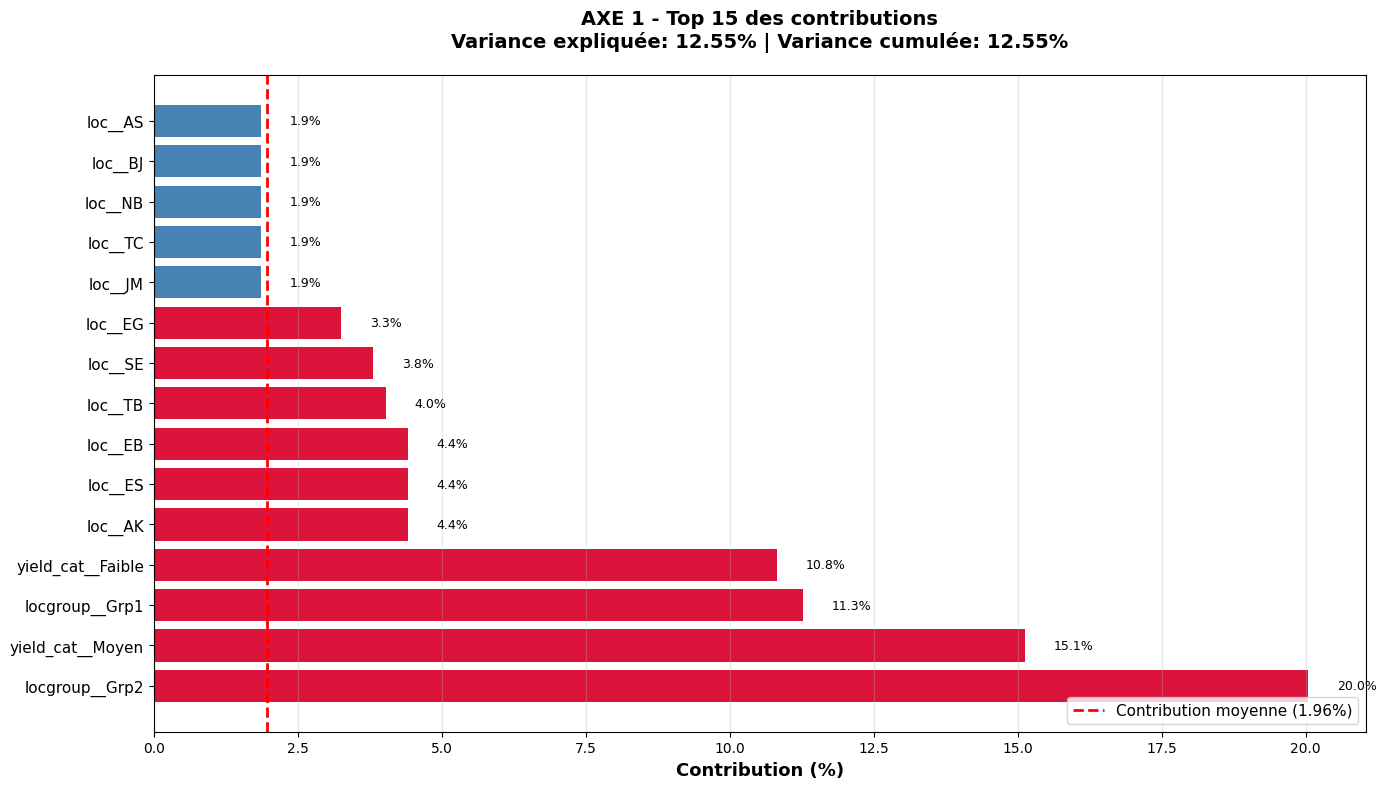




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 2                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 10.94%
📊 Variance cumulée : 23.50%

✓ Somme des contributions : 105.38%
✓ Modalités > moyenne : 16/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
              Coordonnée  Contribution (%)
gengroup__W3    1.408727         28.996789
gengroup__W2   -0.879515         20.344887
gen__G08        1.424706          5.931671
gen__G15        1.421931          5.908585
gen__G13        1.419156          5.885544
gen__G03        1.388920          5.637427
gen__G11        1.388920   

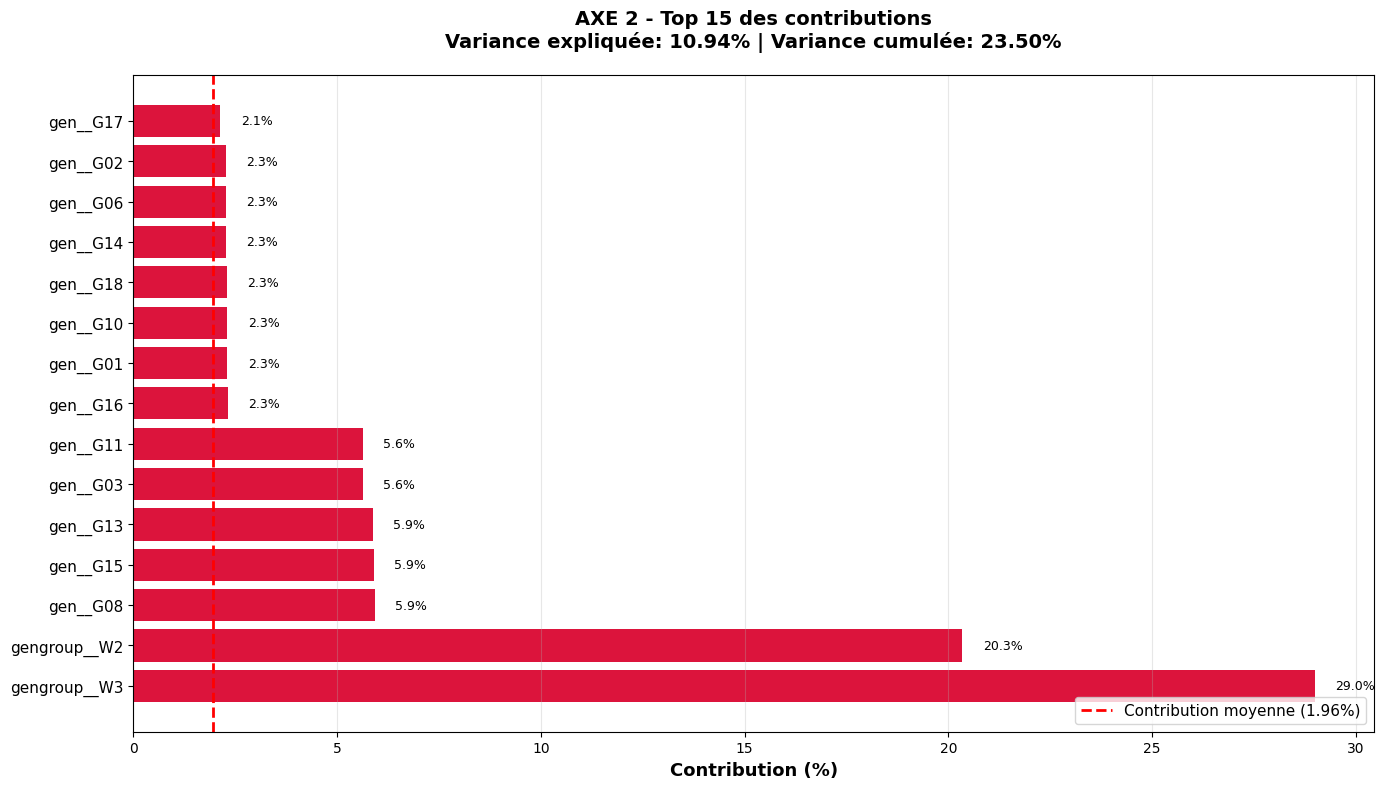




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 3                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 10.93%
📊 Variance cumulée : 34.42%

✓ Somme des contributions : 105.39%
✓ Modalités > moyenne : 7/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
                Coordonnée  Contribution (%)
gengroup__W1      1.829794         39.205465
gen__G09          1.829794          9.801366
gen__G07          1.829794          9.801366
gen__G05          1.829794          9.801366
gen__G04          1.829794          9.801366
gengroup__W3     -0.657032          6.318662
gengroup__W2  

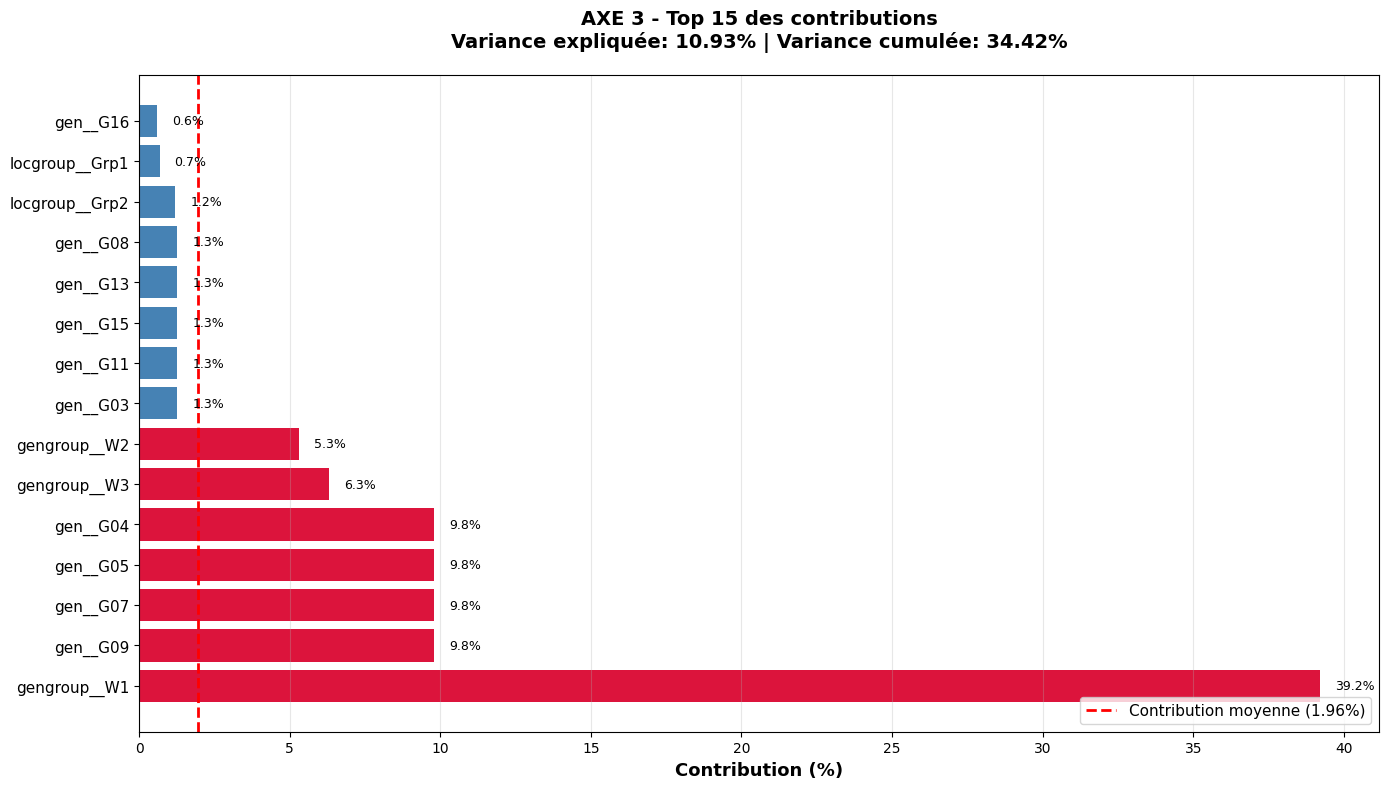




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 4                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 10.35%
📊 Variance cumulée : 44.77%

✓ Somme des contributions : 105.69%
✓ Modalités > moyenne : 3/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
                   Coordonnée  Contribution (%)
yield_cat__Élevé     3.921448         45.637023
loc__MG              4.458567         44.246219
yield_cat__Faible   -0.409275          4.908990
loc__EG              0.807665          1.451939
loc__SG             -0.629597          0.882288
loc__SR             -0.629597          0.

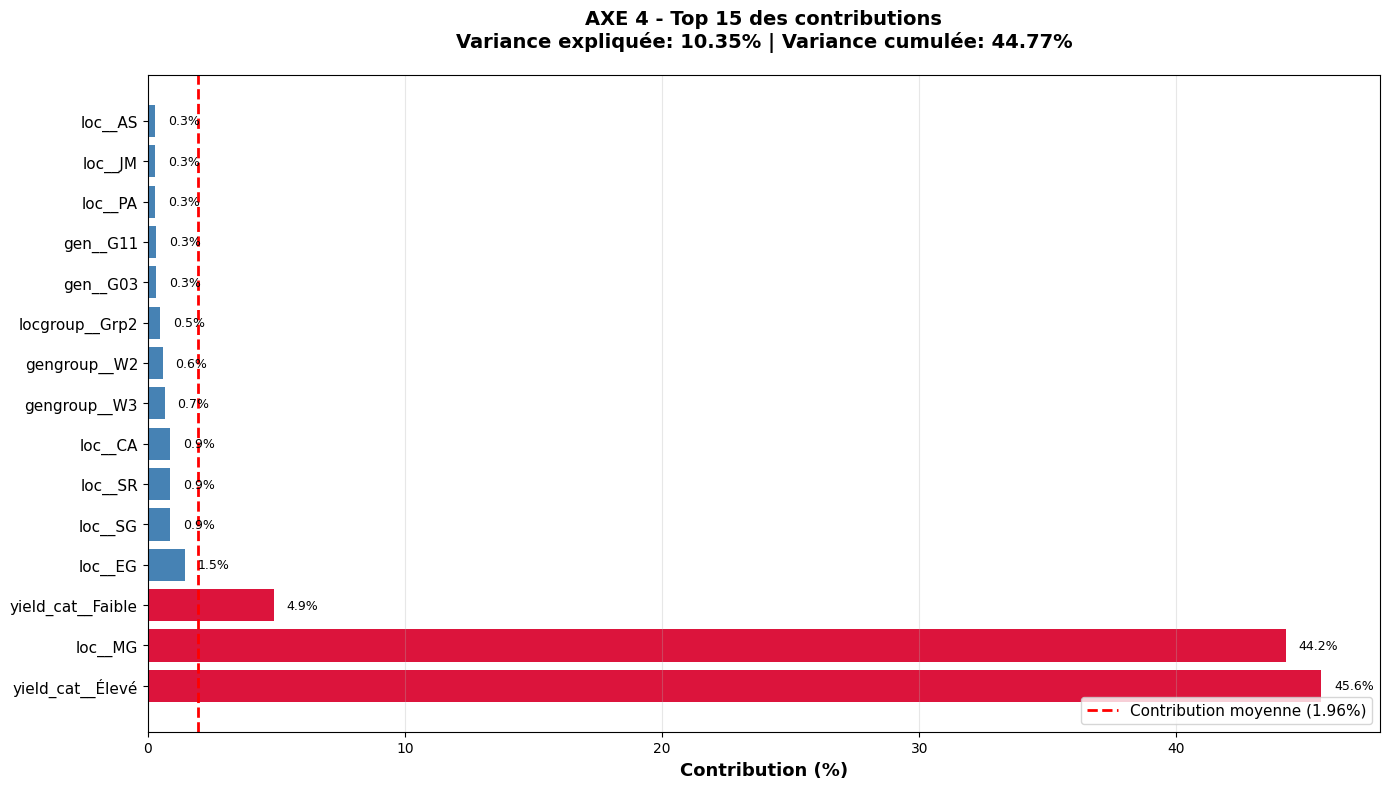




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 5                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 8.71%
📊 Variance cumulée : 53.48%

✓ Somme des contributions : 106.76%
✓ Modalités > moyenne : 14/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
                   Coordonnée  Contribution (%)
yield_cat__Moyen    -0.723241         14.519086
locgroup__Grp2       0.657506         10.285504
loc__SR              1.870383          9.247944
loc__SG              1.870383          9.247944
loc__CA              1.870383          9.247944
yield_cat__Faible    0.493435          8.

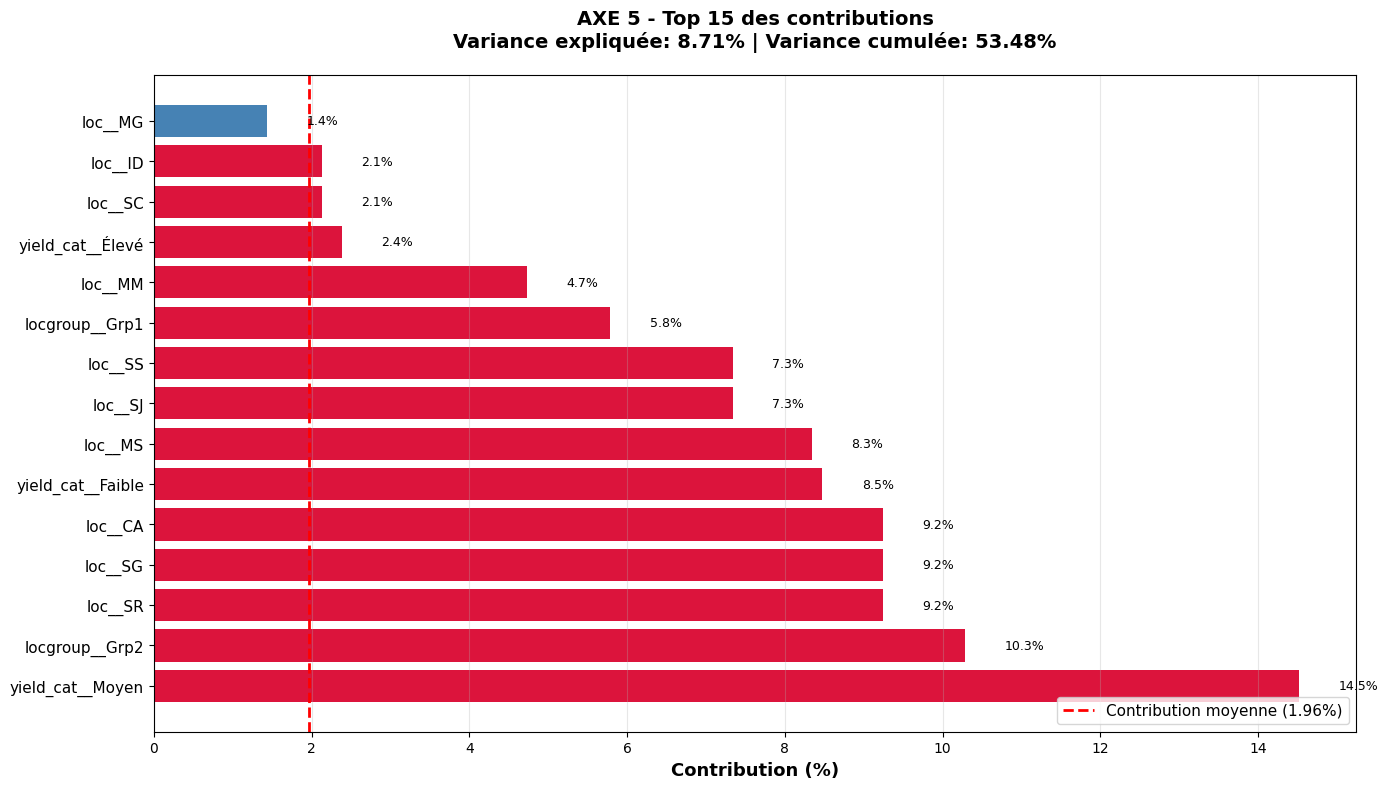




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 6                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 5.17%
📊 Variance cumulée : 58.65%

✓ Somme des contributions : 111.39%
✓ Modalités > moyenne : 20/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
          Coordonnée  Contribution (%)
loc__BJ     1.897774         16.046501
gen__G01    1.345317         11.199738
loc__JM     1.475424          9.698958
loc__MS    -1.290643          7.421706
loc__MM    -1.189213          6.301011
loc__SG    -1.090493          5.298305
gen__G16   -0.862630          4.604769
loc__SC    -0.976

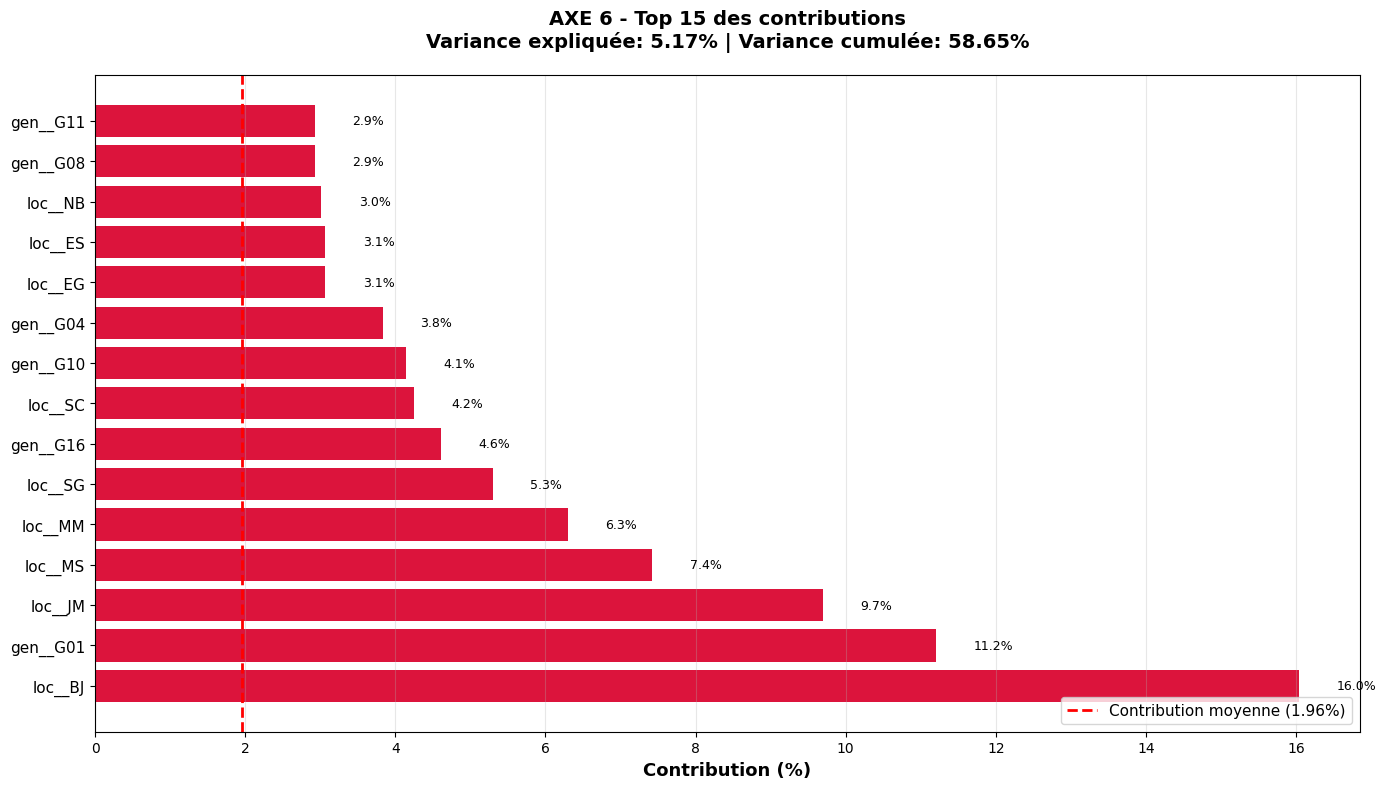




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 7                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 5.17%
📊 Variance cumulée : 63.82%

✓ Somme des contributions : 111.39%
✓ Modalités > moyenne : 18/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
          Coordonnée  Contribution (%)
loc__MS     1.779293         14.105427
gen__G03    1.093820          7.403726
loc__TB    -1.280412          7.304506
loc__SG     1.245001          6.906062
loc__EG     1.218965          6.620243
loc__KN     1.152258          5.915493
gen__G07   -0.945336          5.530078
loc__EB    -1.069

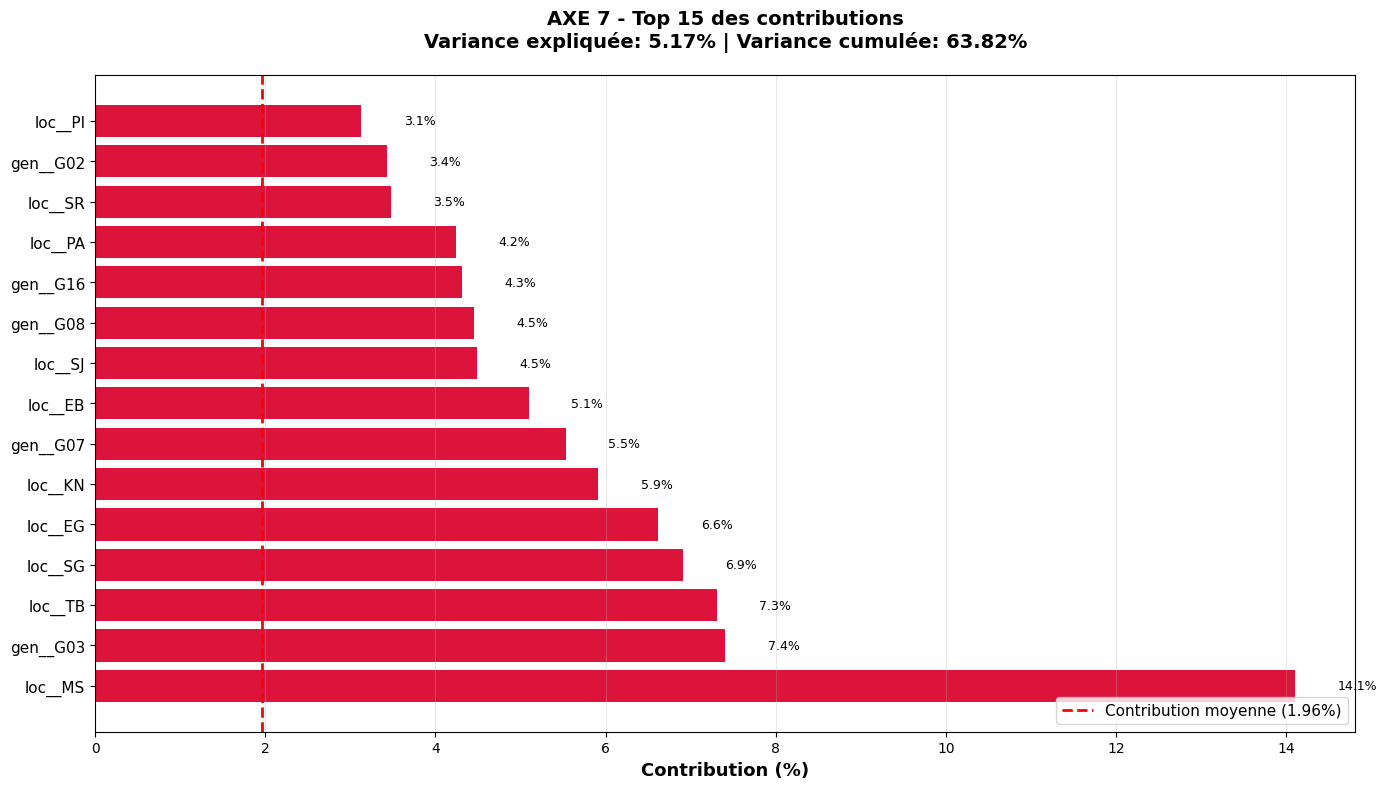




████████████████████████████████████████████████████████████████████████████████████████████████████
                                               AXE 8                                                
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Variance expliquée : 5.17%
📊 Variance cumulée : 68.99%

✓ Somme des contributions : 111.39%
✓ Modalités > moyenne : 18/51

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 15 MODALITÉS CONTRIBUANT LE PLUS
────────────────────────────────────────────────────────────────────────────────────────────────────
          Coordonnée  Contribution (%)
loc__PI     1.952818         16.990835
gen__G18   -1.452093         13.048104
loc__BJ     1.378345          8.464608
loc__NB    -1.115980          5.548863
loc__SS     1.094596          5.338251
gen__G13    0.924948          5.294119
loc__SR     1.016158          4.600589
loc__KN    -1.009

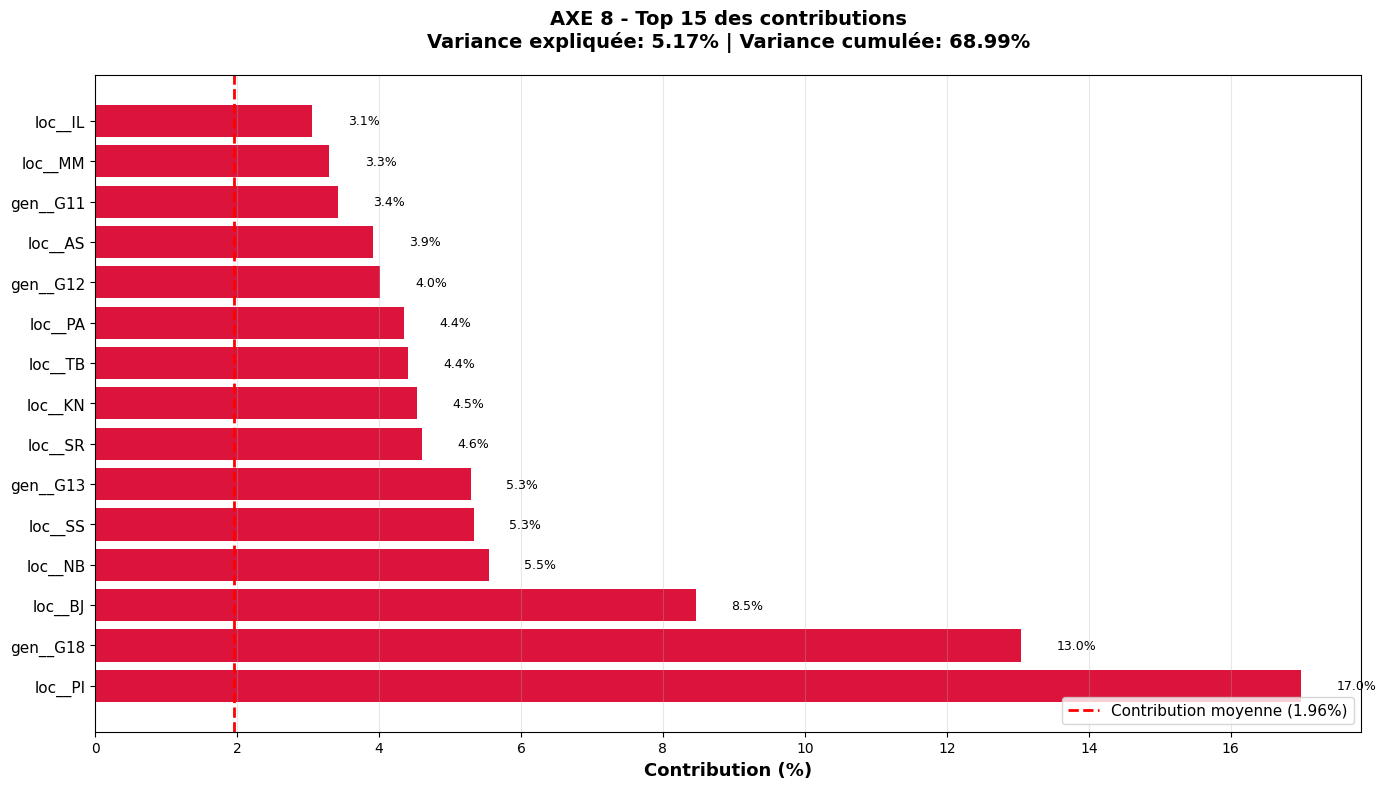



SYNTHÈSE DES 8 AXES
 Axe  Variance (%)  Variance_cumul (%)     Modalité_top  Contrib_max (%)  Somme_contrib (%)
   1     12.553803           12.553803   locgroup__Grp2        20.044379         104.687907
   2     10.944853           23.498656     gengroup__W3        28.996789         105.377053
   3     10.925827           34.424483     gengroup__W1        39.205465         105.386417
   4     10.346258           44.770741 yield_cat__Élevé        45.637023         105.688149
   5      8.711335           53.482076 yield_cat__Moyen        14.519086         106.755688
   6      5.168658           58.650734          loc__BJ        16.046501         111.386139
   7      5.168658           63.819393          loc__MS        14.105427         111.386139
   8      5.168658           68.988051          loc__PI        16.990835         111.386139

✅ Analyse complète des contributions terminée !


In [98]:
# =====================================================
# CONTRIBUTIONS DES MODALITÉS PAR AXE (GREENACRE) - SOLUTION FINALE
# =====================================================

# Obtenir les coordonnées des modalités
column_coords = mca.column_coordinates(donnees)

print("=" * 100)
print("CALCUL DES MASSES CORRECTES")
print("=" * 100)

# Les noms sont au format "variable__modalite" avec DOUBLE underscore
masses_list = []

for idx in column_coords.index:
    # Split sur le double underscore
    if '__' in idx:
        variable, modalite = idx.split('__', 1)  # Split seulement au premier __

        # Vérifier que la variable existe
        if variable in variables_qualitatives:
            # Calculer la masse (fréquence de cette modalité)
            masse = (donnees[variable] == modalite).sum() / len(donnees)
            masses_list.append(masse)
        else:
            print(f"⚠️ Variable inconnue : {variable}")
            masses_list.append(0)
    else:
        print(f"⚠️ Format inattendu : {idx}")
        masses_list.append(0)

masses = np.array(masses_list)

print(f"\nNombre de masses : {len(masses)}")
print(f"Somme des masses : {masses.sum():.6f} (devrait être ≈ {len(variables_qualitatives)}.0)")
print(f"Min masse : {masses.min():.6f}")
print(f"Max masse : {masses.max():.6f}")

# Vérification détaillée
print(f"\nExemples de masses calculées :")
for i in range(min(10, len(masses))):
    print(f"  {column_coords.index[i]} -> {masses[i]:.4f}")

# =====================================================
# CALCUL DES CONTRIBUTIONS AVEC CORRECTION
# =====================================================

# La somme des masses = K (nombre de variables)
# Pour l'ACM, il faut diviser par K pour normaliser
K = len(variables_qualitatives)
masses_normalisees = masses / K

print(f"\n{'=' * 100}")
print("MASSES NORMALISÉES")
print("=" * 100)
print(f"Somme des masses normalisées : {masses_normalisees.sum():.6f} (devrait être ≈ 1.0)")

contributions = pd.DataFrame(index=column_coords.index)
n_axes = 8

print(f"\n{'=' * 100}")
print("CALCUL DES CONTRIBUTIONS")
print("=" * 100)

for i in range(n_axes):
    if i < len(lambda_greenacre) and lambda_greenacre[i] > 0:
        coord_axe = column_coords.iloc[:, i].values

        # Formule : contribution = (coordonnée² × masse_normalisée) / valeur_propre × 100
        contrib = ((coord_axe ** 2) * masses_normalisees) / lambda_greenacre[i] * 100

        contributions[f'Contrib_Axe_{i+1}'] = contrib
        contributions[f'Coord_Axe_{i+1}'] = coord_axe

        somme_contrib = contrib.sum()
        max_contrib = contrib.max()

        statut = "✅" if (90 <= somme_contrib <= 110) else "⚠️"
        print(f"{statut} Axe {i+1}: Somme = {somme_contrib:.2f}%, Max = {max_contrib:.2f}%")
    else:
        contributions[f'Contrib_Axe_{i+1}'] = 0
        contributions[f'Coord_Axe_{i+1}'] = 0

contribution_moyenne = 100 / len(contributions)

# =====================================================
# AFFICHAGE PAR AXE
# =====================================================

print(f"\n{'=' * 100}")
print(f"ANALYSE DES CONTRIBUTIONS PAR AXE (Contribution moyenne = {contribution_moyenne:.2f}%)")
print("=" * 100)

for axe in range(1, n_axes + 1):
    print("\n" + "█" * 100)
    print(f"{'AXE ' + str(axe):^100}")
    print("█" * 100)

    if axe - 1 < len(pourcentage_greenacre):
        variance = pourcentage_greenacre[axe - 1]
        variance_cumul = cumul_greenacre[axe - 1]
        print(f"\n📊 Variance expliquée : {variance:.2f}%")
        print(f"📊 Variance cumulée : {variance_cumul:.2f}%")

    contrib_axe = contributions[[f'Coord_Axe_{axe}', f'Contrib_Axe_{axe}']].copy()
    contrib_axe.columns = ['Coordonnée', 'Contribution (%)']
    contrib_axe = contrib_axe.sort_values('Contribution (%)', ascending=False)

    somme = contrib_axe['Contribution (%)'].sum()
    nb_sup_moyenne = (contrib_axe['Contribution (%)'] > contribution_moyenne).sum()

    print(f"\n✓ Somme des contributions : {somme:.2f}%")
    print(f"✓ Modalités > moyenne : {nb_sup_moyenne}/{len(contrib_axe)}")

    print(f"\n{'─' * 100}")
    print(f"TOP 15 MODALITÉS CONTRIBUANT LE PLUS")
    print("─" * 100)
    print(contrib_axe.head(15).to_string())

    # Graphique
    plt.figure(figsize=(14, 8))
    top_15 = contrib_axe.head(15)
    colors = ['crimson' if x > contribution_moyenne else 'steelblue'
              for x in top_15['Contribution (%)']]

    bars = plt.barh(range(len(top_15)), top_15['Contribution (%)'], color=colors)
    plt.yticks(range(len(top_15)), top_15.index, fontsize=11)
    plt.xlabel('Contribution (%)', fontsize=13, fontweight='bold')

    title = f'AXE {axe} - Top 15 des contributions\n'
    title += f'Variance expliquée: {variance:.2f}% | Variance cumulée: {variance_cumul:.2f}%'
    plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.axvline(x=contribution_moyenne, color='red', linestyle='--',
                linewidth=2, label=f'Contribution moyenne ({contribution_moyenne:.2f}%)')

    # Ajouter les valeurs sur les barres
    for i, (idx, row) in enumerate(top_15.iterrows()):
        plt.text(row['Contribution (%)'] + 0.5, i, f"{row['Contribution (%)']:.1f}%",
                va='center', fontsize=9)

    plt.legend(fontsize=11, loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n")

# =====================================================
# TABLEAU DE SYNTHÈSE
# =====================================================

print("=" * 100)
print("SYNTHÈSE DES 8 AXES")
print("=" * 100)

synthese = pd.DataFrame({
    'Axe': range(1, n_axes + 1),
    'Variance (%)': [pourcentage_greenacre[i] if i < len(pourcentage_greenacre) else 0
                     for i in range(n_axes)],
    'Variance_cumul (%)': [cumul_greenacre[i] if i < len(cumul_greenacre) else 0
                           for i in range(n_axes)],
    'Modalité_top': [contributions[f'Contrib_Axe_{i+1}'].idxmax() for i in range(n_axes)],
    'Contrib_max (%)': [contributions[f'Contrib_Axe_{i+1}'].max() for i in range(n_axes)],
    'Somme_contrib (%)': [contributions[f'Contrib_Axe_{i+1}'].sum() for i in range(n_axes)]
})

print(synthese.to_string(index=False))

print("\n✅ Analyse complète des contributions terminée !")

TOP 15 MODALITÉS - Axe 1
                   Coordonnée  Contribution (%)
locgroup__Grp2       1.101865         20.044379
yield_cat__Moyen     0.886171         15.125779
locgroup__Grp1      -0.619799         11.274963
yield_cat__Faible   -0.669181         10.815741
loc__AK              1.549794          4.405972
loc__ES              1.549794          4.405972
loc__EB              1.549794          4.405972
loc__TB              1.482434          4.031291
loc__SE              1.440950          3.808827
loc__EG              1.332105          3.255148
loc__JM             -1.004838          1.852190
loc__TC             -1.004838          1.852190
loc__NB             -1.004838          1.852190
loc__BJ             -1.004838          1.852190
loc__AS             -1.004838          1.852190


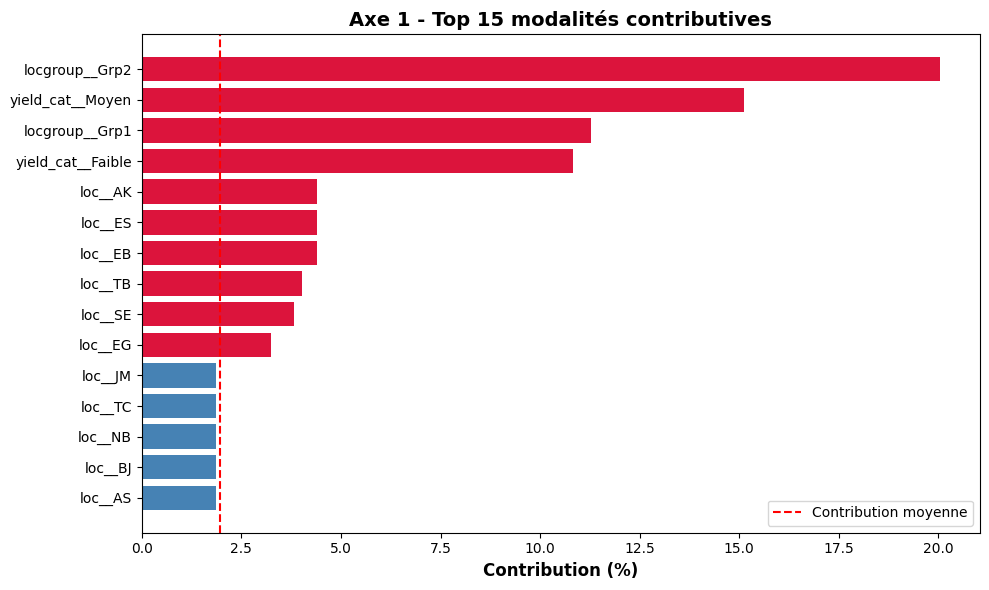

TOP 15 MODALITÉS - Axe 2
              Coordonnée  Contribution (%)
gengroup__W3    1.408727         28.996789
gengroup__W2   -0.879515         20.344887
gen__G08        1.424706          5.931671
gen__G15        1.421931          5.908585
gen__G13        1.419156          5.885544
gen__G03        1.388920          5.637427
gen__G11        1.388920          5.637427
gen__G16       -0.891784          2.324053
gen__G01       -0.889009          2.309611
gen__G10       -0.889009          2.309611
gen__G18       -0.886234          2.295214
gen__G14       -0.883459          2.280862
gen__G06       -0.883459          2.280862
gen__G02       -0.883459          2.280862
gen__G17       -0.855998          2.141273


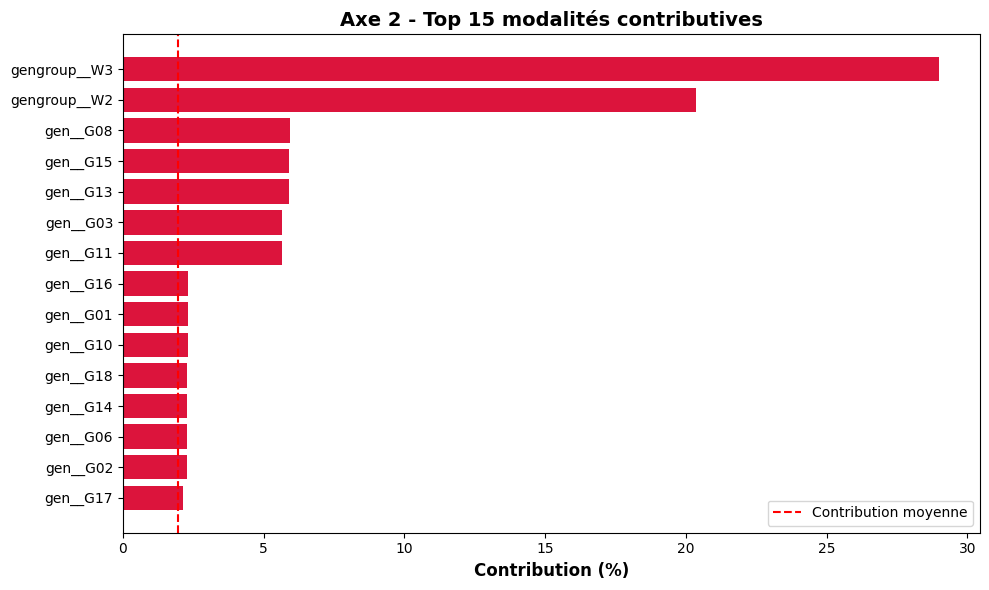

TOP 15 MODALITÉS - Axe 3
                Coordonnée  Contribution (%)
gengroup__W1      1.829794         39.205465
gen__G09          1.829794          9.801366
gen__G07          1.829794          9.801366
gen__G05          1.829794          9.801366
gen__G04          1.829794          9.801366
gengroup__W3     -0.657032          6.318662
gengroup__W2     -0.448224          5.293160
gen__G03         -0.657032          1.263732
gen__G11         -0.657032          1.263732
gen__G15         -0.657032          1.263732
gen__G13         -0.657032          1.263732
gen__G08         -0.657032          1.263732
locgroup__Grp2   -0.251576          1.200590
locgroup__Grp1    0.141511          0.675332
gen__G16         -0.448224          0.588129


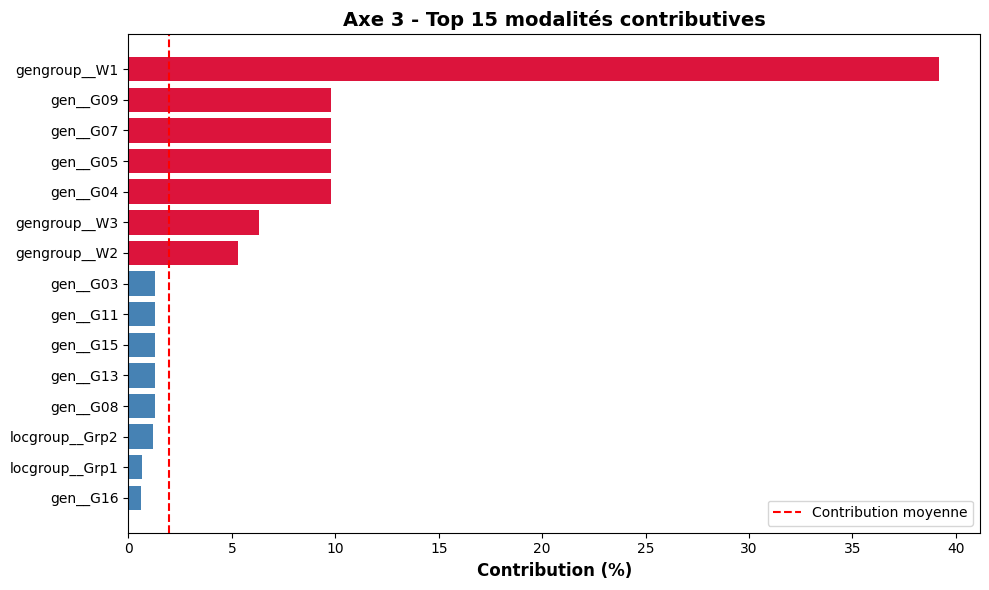

TOP 15 MODALITÉS - Axe 4
                   Coordonnée  Contribution (%)
yield_cat__Élevé     3.921448         45.637023
loc__MG              4.458567         44.246219
yield_cat__Faible   -0.409275          4.908990
loc__EG              0.807665          1.451939
loc__SG             -0.629597          0.882288
loc__SR             -0.629597          0.882288
loc__CA             -0.629597          0.882288
gengroup__W3        -0.205848          0.654961
gengroup__W2         0.144341          0.579660
locgroup__Grp2      -0.156941          0.493399
gen__G03            -0.321420          0.319373
gen__G11            -0.321420          0.319373
loc__PA             -0.356928          0.283561
loc__JM             -0.356928          0.283561
loc__AS             -0.356928          0.283561


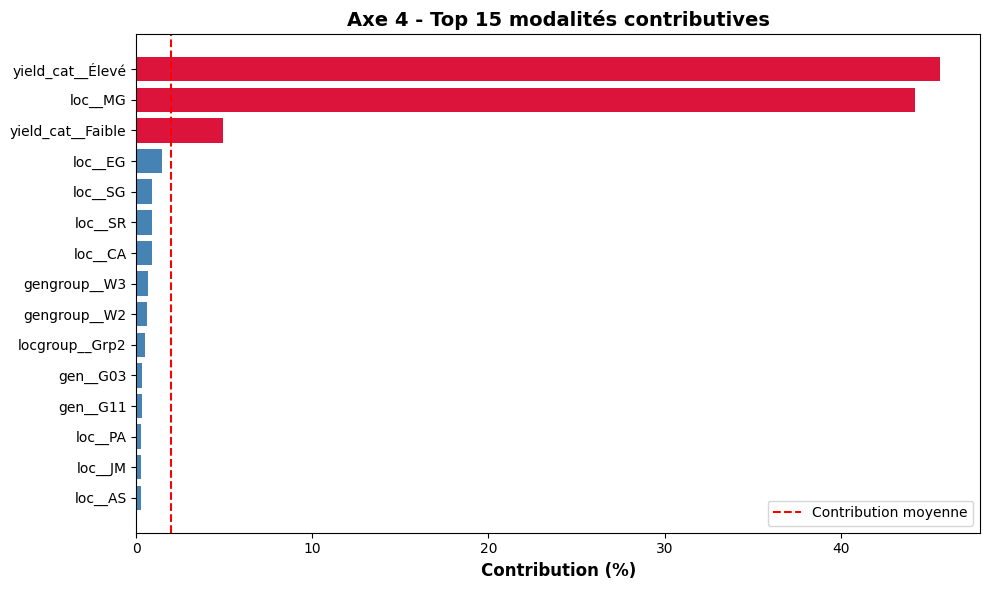

TOP 15 MODALITÉS - Axe 5
                   Coordonnée  Contribution (%)
yield_cat__Moyen    -0.723241         14.519086
locgroup__Grp2       0.657506         10.285504
loc__SR              1.870383          9.247944
loc__SG              1.870383          9.247944
loc__CA              1.870383          9.247944
yield_cat__Faible    0.493435          8.474627
loc__MS             -1.776366          8.341594
loc__SJ             -1.666521          7.341855
loc__SS             -1.666521          7.341855
locgroup__Grp1      -0.369847          5.785596
loc__MM             -1.336986          4.725395
yield_cat__Élevé     0.822846          2.386495
loc__SC             -0.897607          2.129886
loc__ID             -0.897607          2.129886
loc__MG              0.736165          1.432632


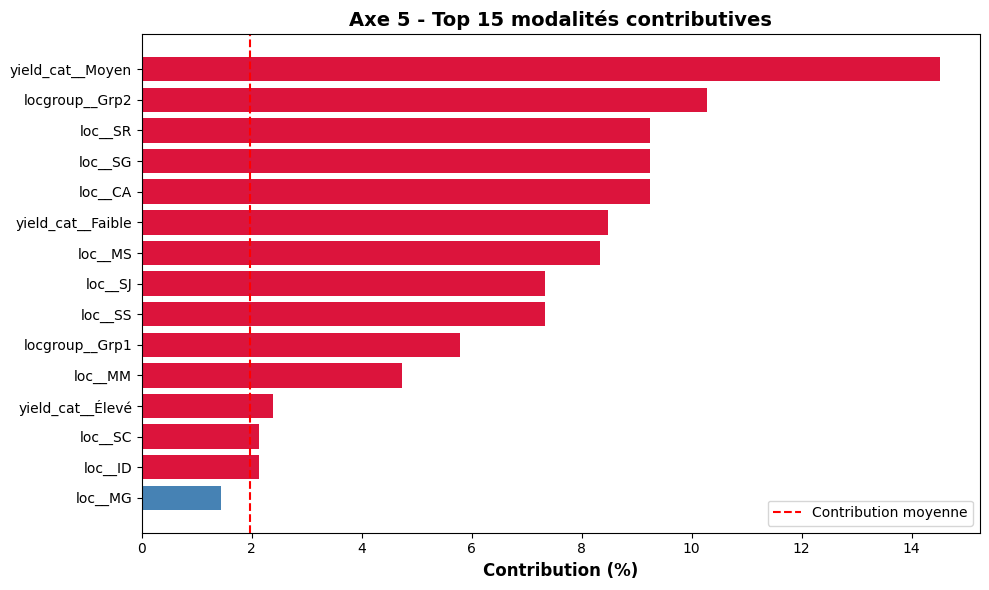

TOP 15 MODALITÉS - Axe 6
          Coordonnée  Contribution (%)
loc__BJ     1.897774         16.046501
gen__G01    1.345317         11.199738
loc__JM     1.475424          9.698958
loc__MS    -1.290643          7.421706
loc__MM    -1.189213          6.301011
loc__SG    -1.090493          5.298305
gen__G16   -0.862630          4.604769
loc__SC    -0.976395          4.247588
gen__G10   -0.818000          4.140616
gen__G04   -0.786650          3.829324
loc__EG     0.829623          3.066567
loc__ES     0.829406          3.064963
loc__NB    -0.822522          3.014296
gen__G08   -0.687980          2.928940
gen__G11    0.687445          2.924383


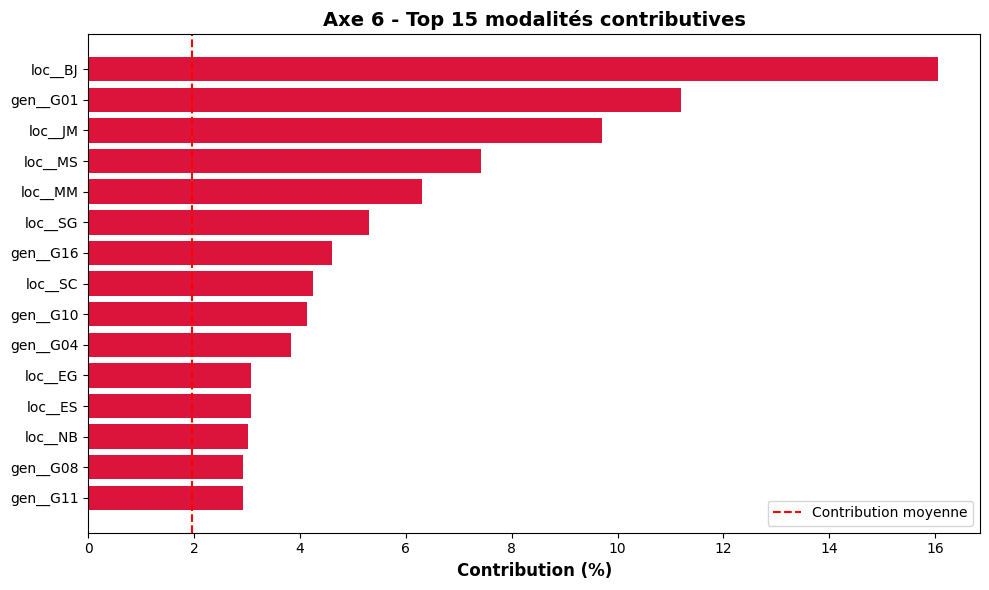

TOP 15 MODALITÉS - Axe 7
          Coordonnée  Contribution (%)
loc__MS     1.779293         14.105427
gen__G03    1.093820          7.403726
loc__TB    -1.280412          7.304506
loc__SG     1.245001          6.906062
loc__EG     1.218965          6.620243
loc__KN     1.152258          5.915493
gen__G07   -0.945336          5.530078
loc__EB    -1.069724          5.098404
loc__SJ    -1.003506          4.486743
gen__G08   -0.848396          4.454055
gen__G16   -0.834185          4.306095
loc__PA    -0.976048          4.244567
loc__SR    -0.883044          3.474207
gen__G02    0.744414          3.429160
loc__PI    -0.837559          3.125517


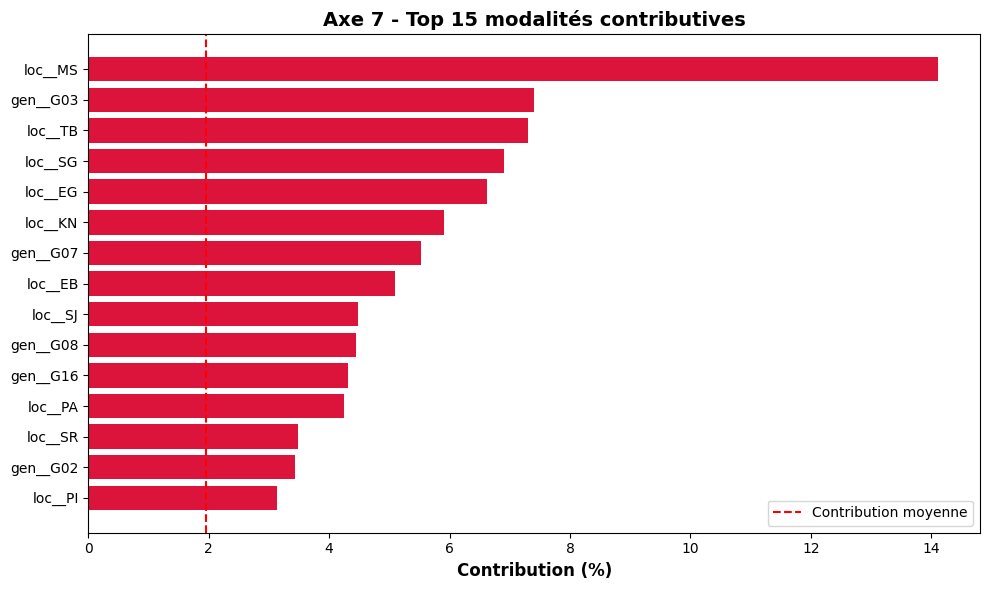

TOP 15 MODALITÉS - Axe 8
          Coordonnée  Contribution (%)
loc__PI     1.952818         16.990835
gen__G18   -1.452093         13.048104
loc__BJ     1.378345          8.464608
loc__NB    -1.115980          5.548863
loc__SS     1.094596          5.338251
gen__G13    0.924948          5.294119
loc__SR     1.016158          4.600589
loc__KN    -1.009195          4.537759
loc__TB    -0.994398          4.405670
loc__PA    -0.988461          4.353217
gen__G12    0.805098          4.011033
loc__AS     0.937832          3.918690
gen__G11   -0.743742          3.422969
loc__MM     0.860884          3.302023
loc__IL    -0.828646          3.059347


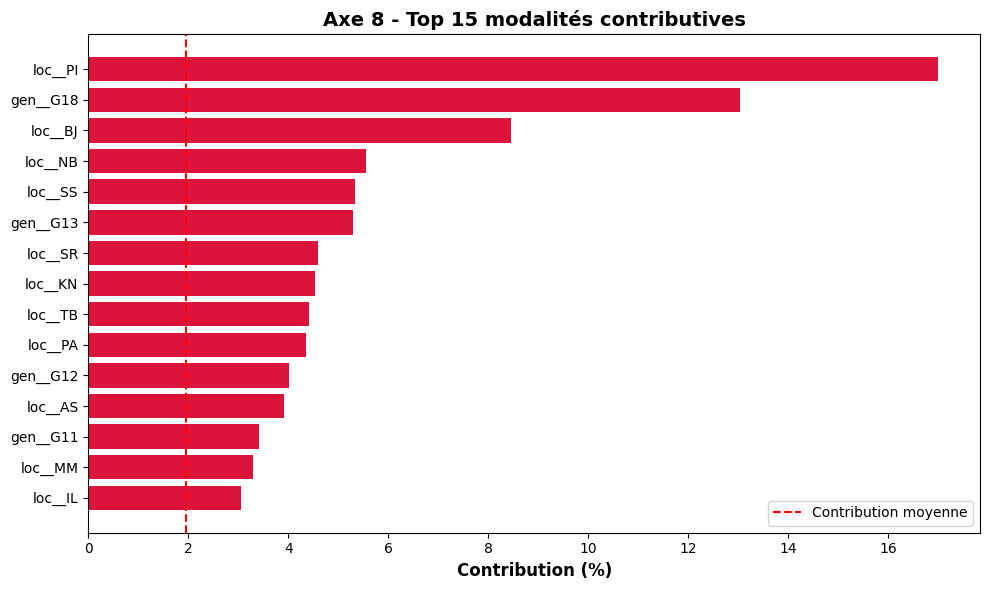

In [106]:
# =====================================================
# TOP 15 MODALITÉS LES PLUS CONTRIBUTIVES POUR TOUS LES AXES
# =====================================================

import pandas as pd
import matplotlib.pyplot as plt

n_axes = 8  # Nombre d'axes à analyser

# DataFrame pour stocker toutes les contributions
contributions_all_axes = pd.DataFrame(index=column_coords_8axes.index)

for axe in range(n_axes):
    coord_axe = column_coords_8axes.iloc[:, axe].values

    # Calcul de la contribution (en %)
    contrib = (coord_axe**2 * masses_normalisees) / lambda_greenacre[axe] * 100

    # Ajouter coordonnées et contributions au DataFrame
    contributions_all_axes[f'Coord_Axe_{axe+1}'] = coord_axe
    contributions_all_axes[f'Contrib_Axe_{axe+1}'] = contrib

# Affichage Top 15 pour chaque axe
for axe in range(n_axes):
    df_axe = contributions_all_axes[[f'Coord_Axe_{axe+1}', f'Contrib_Axe_{axe+1}']].copy()
    df_axe.columns = ['Coordonnée', 'Contribution (%)']
    df_axe = df_axe.sort_values('Contribution (%)', ascending=False)

    top15 = df_axe.head(15)

    print("="*100)
    print(f"TOP 15 MODALITÉS - Axe {axe+1}")
    print("="*100)
    print(top15.to_string())

    # Option graphique
    plt.figure(figsize=(10,6))
    colors = ['crimson' if x > (100/len(column_coords_8axes)) else 'steelblue' for x in top15['Contribution (%)']]
    plt.barh(range(len(top15)), top15['Contribution (%)'], color=colors)
    plt.yticks(range(len(top15)), top15.index)
    plt.xlabel('Contribution (%)', fontsize=12, fontweight='bold')
    plt.title(f'Axe {axe+1} - Top 15 modalités contributives', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Les plus grandes contributions en haut
    plt.axvline(x=100/len(column_coords_8axes), color='red', linestyle='--', label='Contribution moyenne')
    plt.legend()
    plt.tight_layout()
    plt.show()


Nombre de modalités importantes à afficher : 33


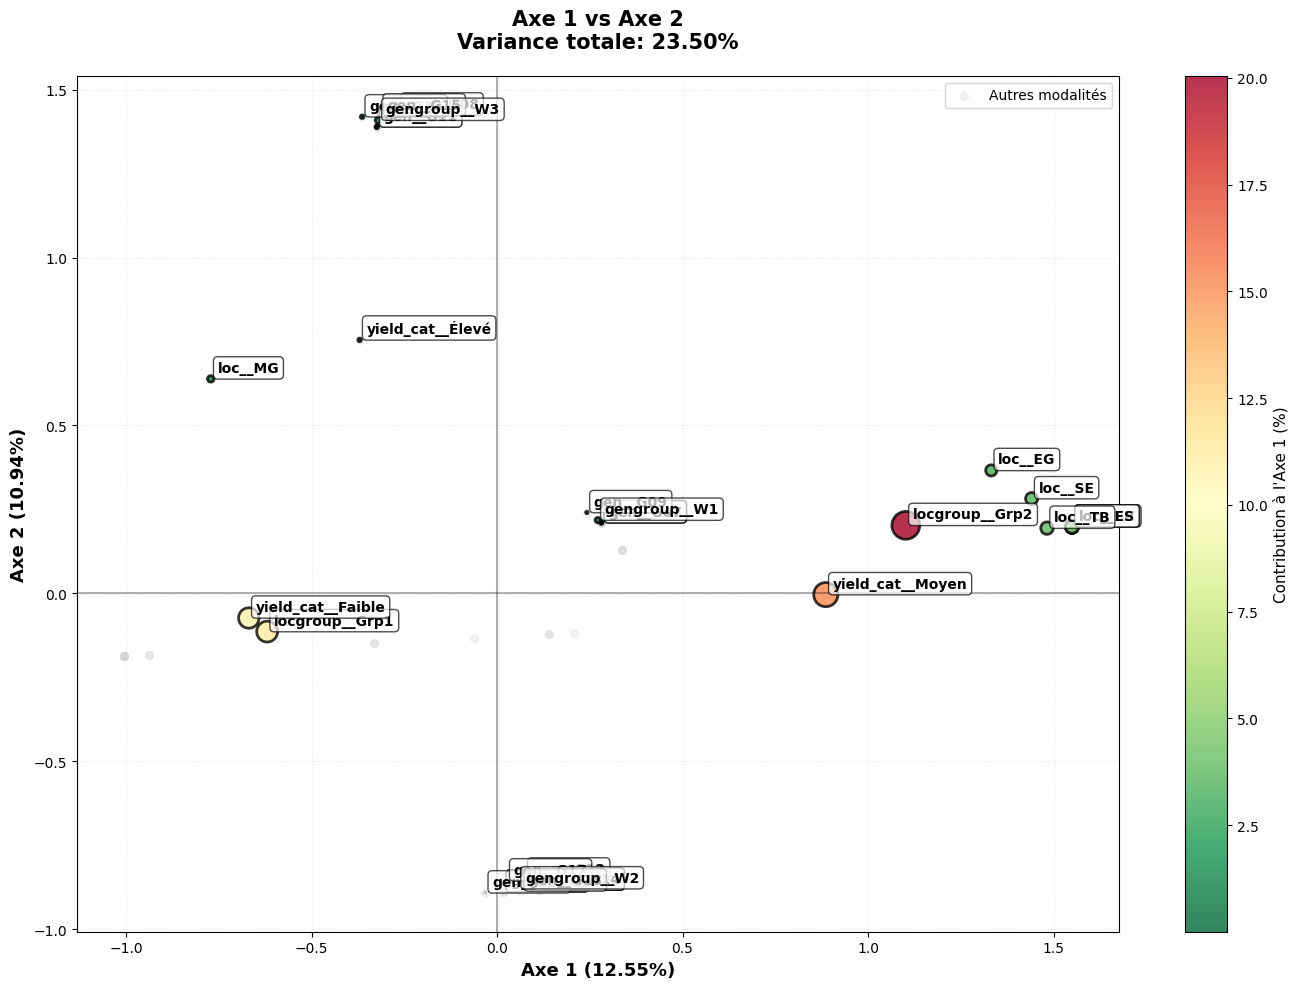

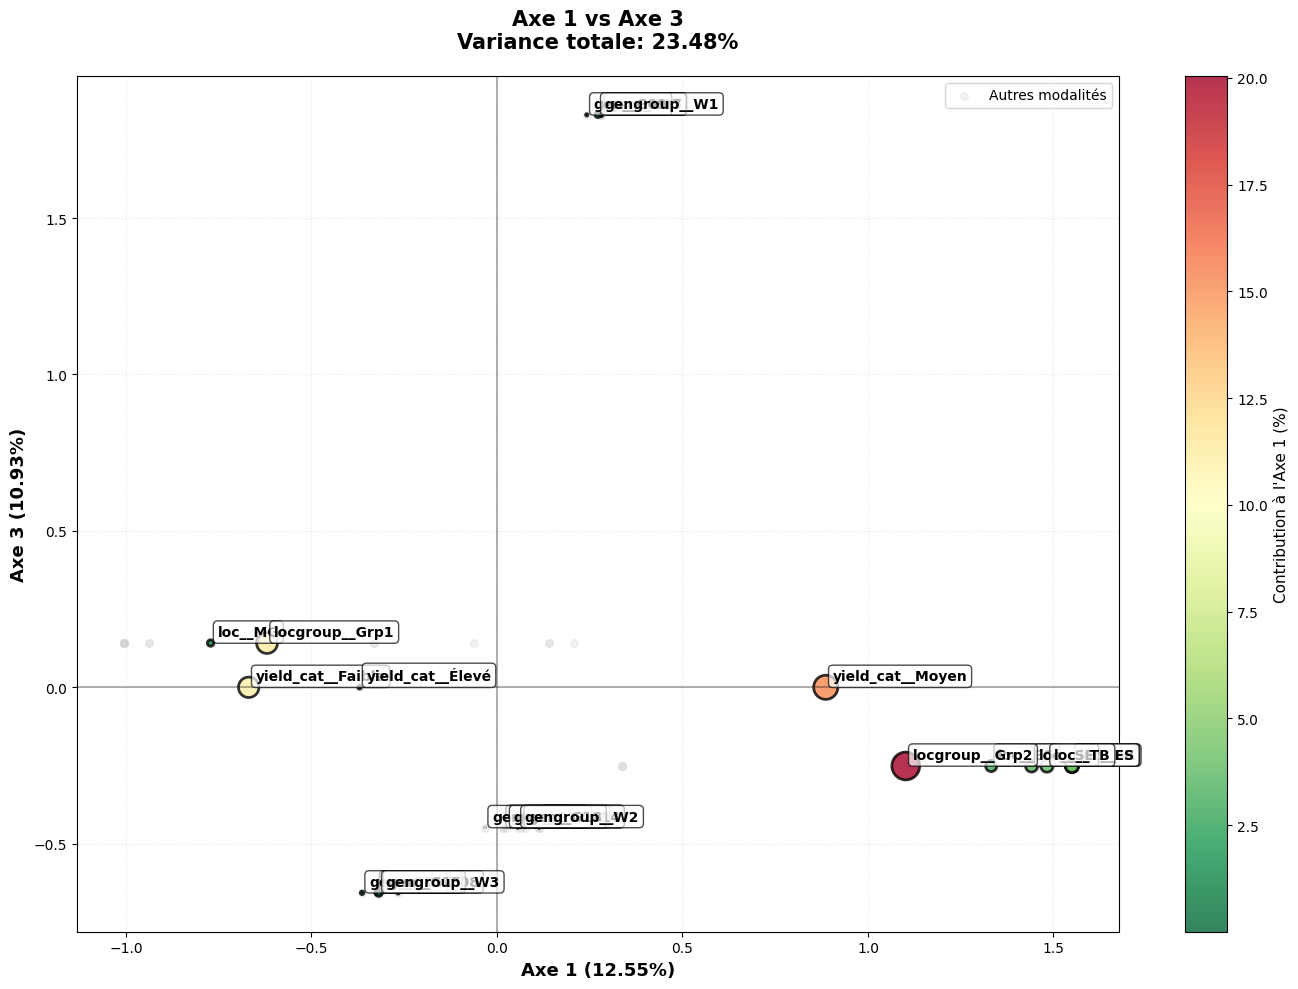

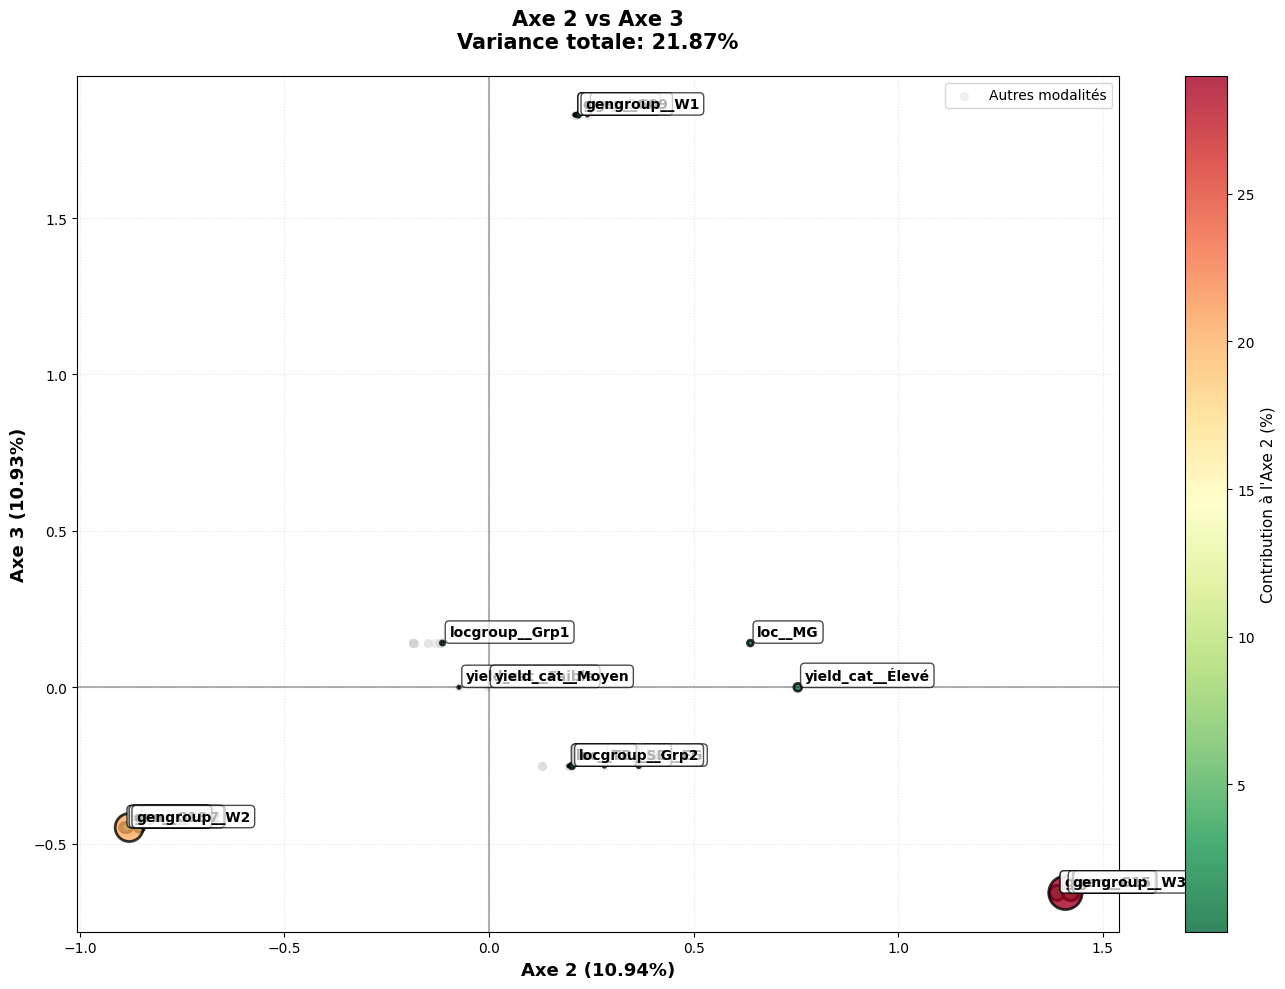

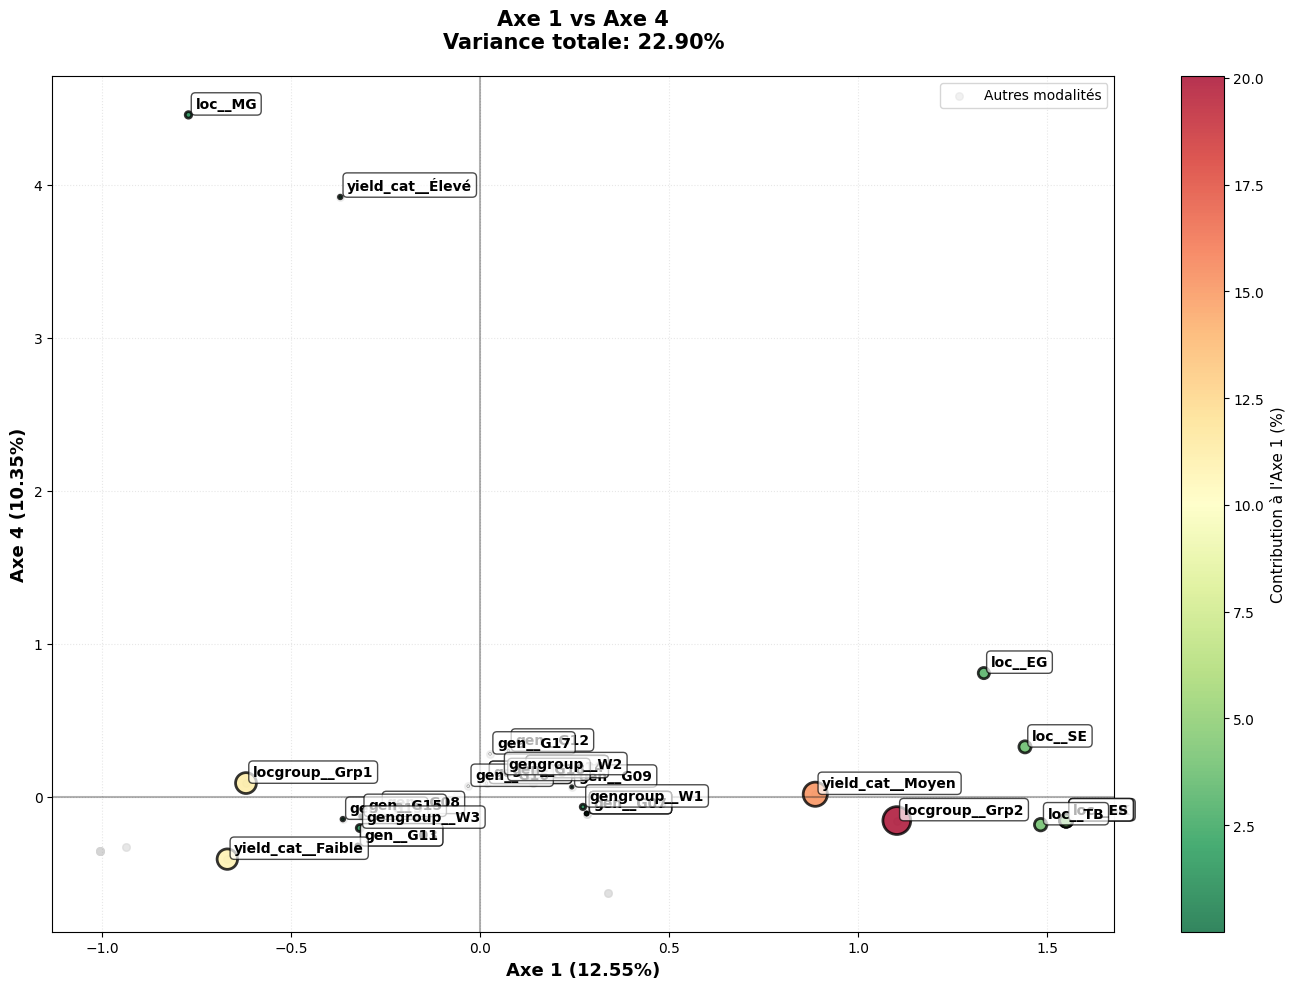


✅ Les 4 plans factoriels ont été générés !


In [100]:
# =====================================================
# 4 PLANS FACTORIELS - VERSION DÉTAILLÉE
# =====================================================

# DÉFINIR D'ABORD les modalités importantes
modalites_importantes = contributions[
    (contributions['Contrib_Axe_1'] > contribution_moyenne) |
    (contributions['Contrib_Axe_2'] > contribution_moyenne) |
    (contributions['Contrib_Axe_3'] > contribution_moyenne) |
    (contributions['Contrib_Axe_4'] > contribution_moyenne)
].index

print(f"Nombre de modalités importantes à afficher : {len(modalites_importantes)}")

# DÉFINIR les 4 plans à visualiser
plans = [
    (0, 1, "Axe 1 vs Axe 2"),  # (index_axe1, index_axe2, titre)
    (0, 2, "Axe 1 vs Axe 3"),
    (1, 2, "Axe 2 vs Axe 3"),
    (0, 3, "Axe 1 vs Axe 4")
]

# Boucle pour créer les 4 graphiques
for axe_x, axe_y, titre in plans:
    plt.figure(figsize=(14, 10))

    # Toutes les modalités en gris clair (contexte)
    plt.scatter(column_coords.iloc[:, axe_x],
               column_coords.iloc[:, axe_y],
               s=30, c='lightgray', alpha=0.3, label='Autres modalités')

    # Modalités importantes en couleur
    x = column_coords.loc[modalites_importantes, axe_x]
    y = column_coords.loc[modalites_importantes, axe_y]
    contrib = contributions.loc[modalites_importantes, f'Contrib_Axe_{axe_x+1}']

    scatter = plt.scatter(x, y, s=contrib*20, c=contrib,
                         cmap='RdYlGn_r', alpha=0.8,
                         edgecolors='black', linewidth=2)

    # Labels
    for i, txt in enumerate(x.index):
        plt.annotate(txt, (x.iloc[i], y.iloc[i]),
                    fontsize=10, fontweight='bold',
                    xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3',
                             facecolor='white', alpha=0.7))

    # Axes de référence
    plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1.5)
    plt.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=1.5)

    # Labels et titre
    var_x = pourcentage_greenacre[axe_x]
    var_y = pourcentage_greenacre[axe_y]
    plt.xlabel(f'Axe {axe_x+1} ({var_x:.2f}%)', fontsize=13, fontweight='bold')
    plt.ylabel(f'Axe {axe_y+1} ({var_y:.2f}%)', fontsize=13, fontweight='bold')
    plt.title(f'{titre}\nVariance totale: {var_x + var_y:.2f}%',
             fontsize=15, fontweight='bold', pad=20)

    # Colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'Contribution à l\'Axe {axe_x+1} (%)', fontsize=11)

    plt.grid(alpha=0.3, linestyle=':')
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

print("\n✅ Les 4 plans factoriels ont été générés !")

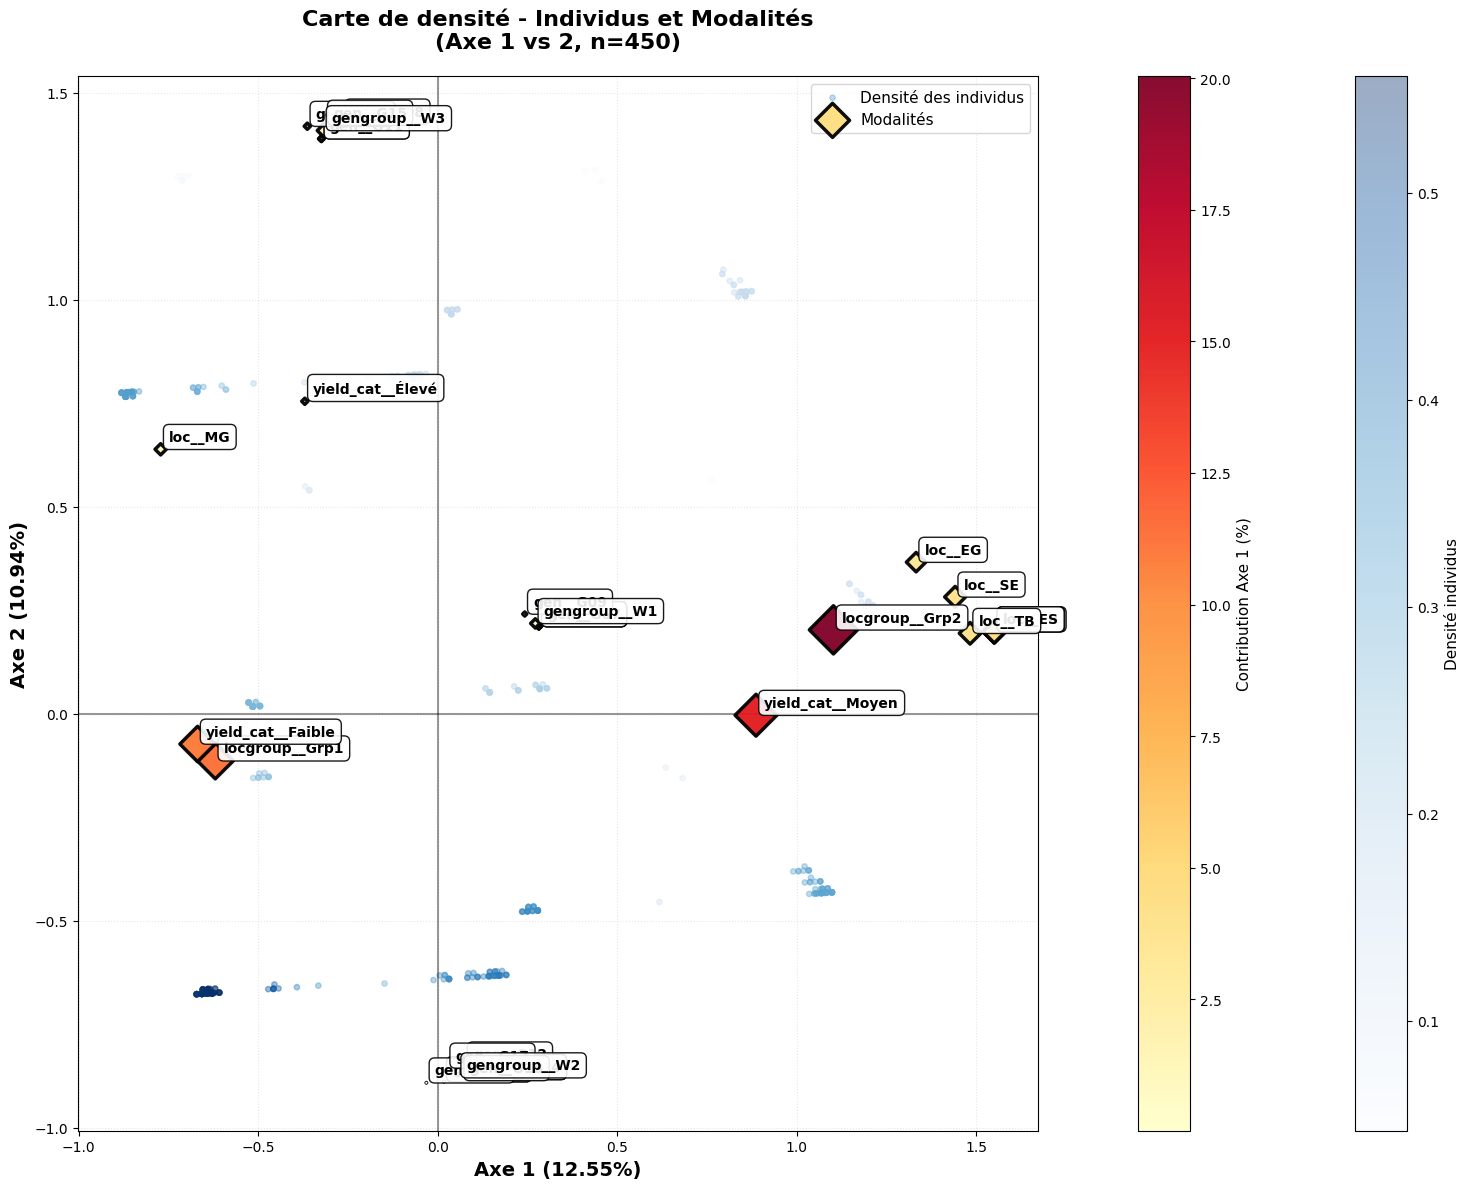

In [101]:
# =====================================================
# CARTE DE DENSITÉ DES INDIVIDUS + MODALITÉS
# =====================================================

from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(16, 12))

# Coordonnées des individus
x_ind = row_coords.iloc[:, 0].values
y_ind = row_coords.iloc[:, 1].values

# Calculer la densité
xy = np.vstack([x_ind, y_ind])
z = gaussian_kde(xy)(xy)

# Carte de densité
scatter_ind = ax.scatter(x_ind, y_ind, c=z, s=15,
                        cmap='Blues', alpha=0.4,
                        label='Densité des individus')

# Modalités importantes par-dessus
x = column_coords.loc[modalites_importantes, 0]
y = column_coords.loc[modalites_importantes, 1]
contrib = contributions.loc[modalites_importantes, 'Contrib_Axe_1']

scatter_mod = ax.scatter(x, y, s=contrib*30, c=contrib,
                        cmap='YlOrRd', alpha=0.95,
                        edgecolors='black', linewidth=2.5,
                        marker='D', label='Modalités', zorder=5)

# Labels
for i, txt in enumerate(x.index):
    ax.annotate(txt, (x.iloc[i], y.iloc[i]),
               fontsize=10, fontweight='bold',
               xytext=(6, 6), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.4',
                        facecolor='white', edgecolor='black', alpha=0.9),
               zorder=6)

# Axes
ax.axhline(0, color='black', linestyle='-', alpha=0.4, linewidth=1.5)
ax.axvline(0, color='black', linestyle='-', alpha=0.4, linewidth=1.5)

# Titre
var_1 = pourcentage_greenacre[0]
var_2 = pourcentage_greenacre[1]
ax.set_xlabel(f'Axe 1 ({var_1:.2f}%)', fontsize=14, fontweight='bold')
ax.set_ylabel(f'Axe 2 ({var_2:.2f}%)', fontsize=14, fontweight='bold')
ax.set_title(f'Carte de densité - Individus et Modalités\n(Axe 1 vs 2, n={len(row_coords)})',
            fontsize=16, fontweight='bold', pad=20)

# Colorbars
cbar1 = plt.colorbar(scatter_ind, ax=ax, pad=0.02)
cbar1.set_label('Densité individus', fontsize=11)

cbar2 = plt.colorbar(scatter_mod, ax=ax, pad=0.08)
cbar2.set_label('Contribution Axe 1 (%)', fontsize=11)

ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

TOP 30 ESSAIS LES PLUS ATYPIQUES (contributifs à l'Axe 1)
 Index Location LocGroup Genotype GenGroup Yield_cat  Coord_Axe1  Coord_Axe2  Contribution
   154       EB     Grp2      G07       W1     Moyen    1.210800    0.260705      0.747026
   156       ES     Grp2      G07       W1     Moyen    1.210800    0.260705      0.747026
   104       EB     Grp2      G05       W1     Moyen    1.210800    0.260705      0.747026
   106       ES     Grp2      G05       W1     Moyen    1.210800    0.260705      0.747026
    79       EB     Grp2      G04       W1     Moyen    1.210800    0.260705      0.747026
    81       ES     Grp2      G04       W1     Moyen    1.210800    0.260705      0.747026
   150       AK     Grp2      G07       W1     Moyen    1.210800    0.260705      0.747026
   100       AK     Grp2      G05       W1     Moyen    1.210800    0.260705      0.747026
    75       AK     Grp2      G04       W1     Moyen    1.210800    0.260705      0.747026
   204       EB     Grp2      G0

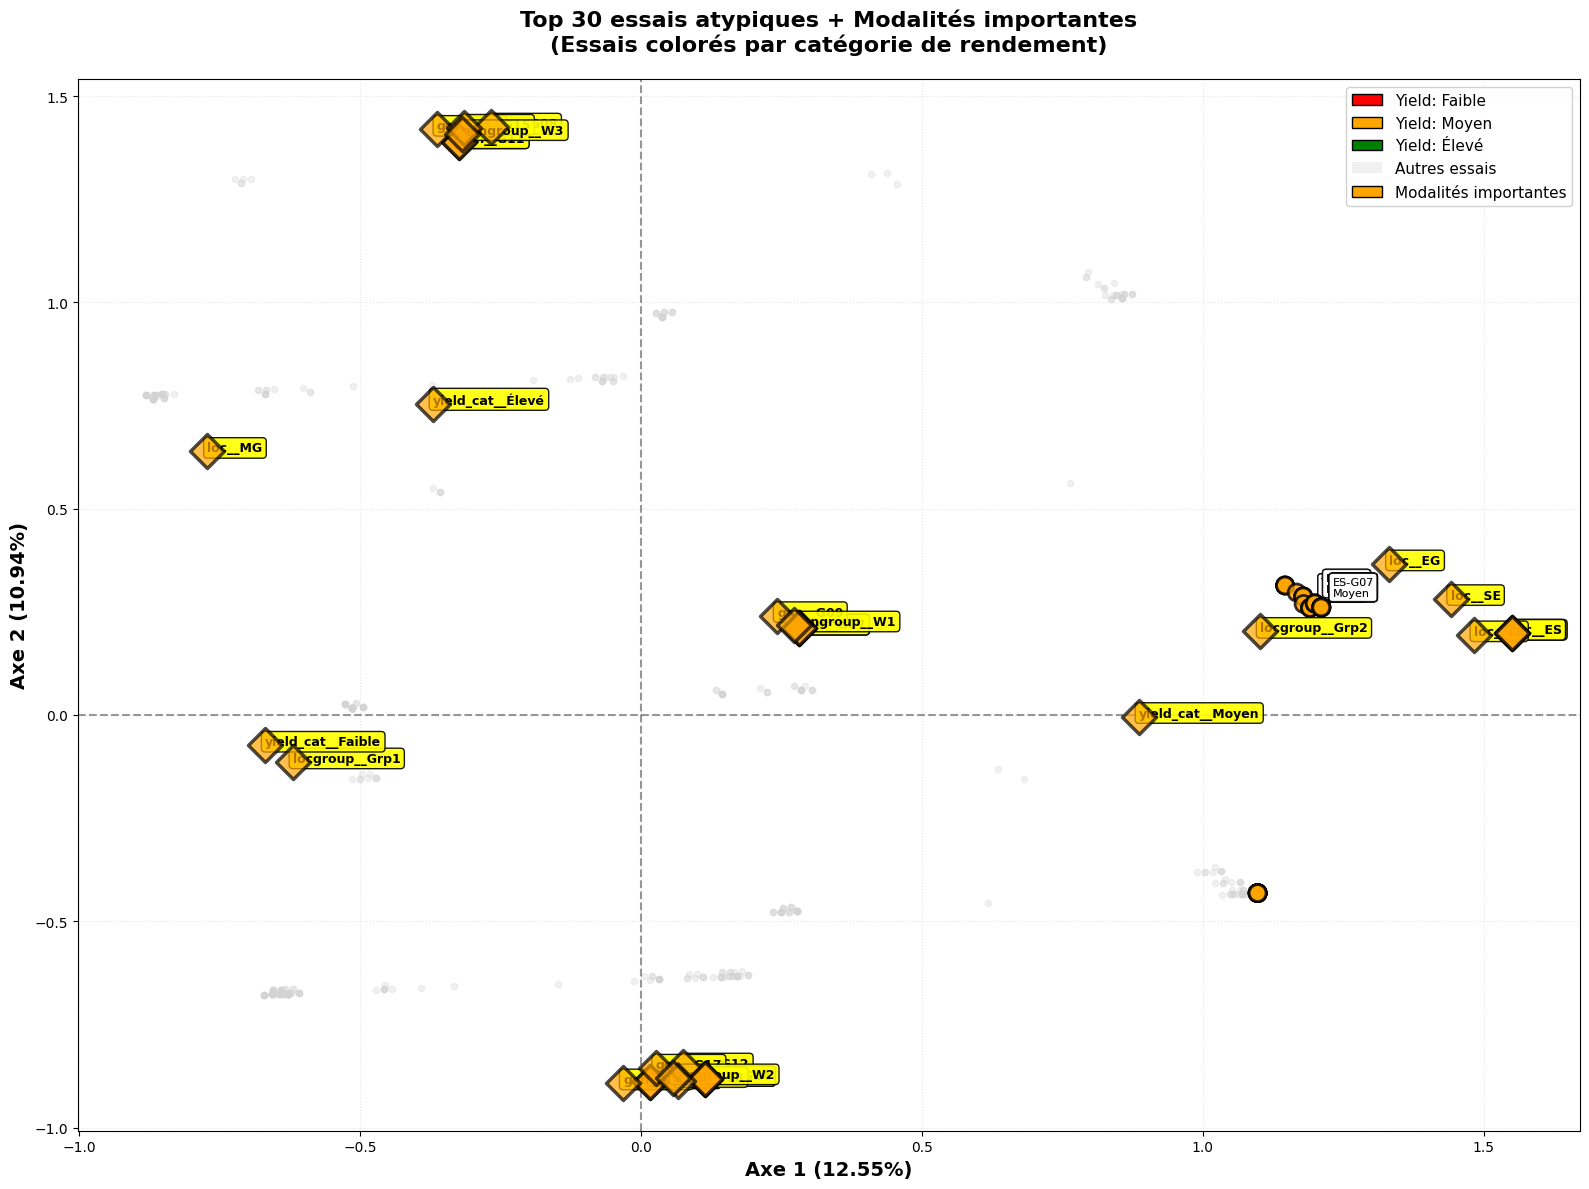


STATISTIQUES DES ESSAIS EXTRÊMES

Distribution des rendements dans le top 30 :
Yield_cat
Moyen     30
Faible     0
Élevé      0
Name: count, dtype: int64

Localisations les plus représentées dans le top 30 :
Location
EB    7
ES    7
AK    5
TB    4
SE    4
Name: count, dtype: int64

Génotypes les plus représentés dans le top 30 :
Genotype
G07    6
G05    6
G04    6
G09    5
G14    3
Name: count, dtype: int64


In [103]:
# =====================================================
# TOP 30 ESSAIS EXTRÊMES (avec détails loc + gen + yield)
# =====================================================

# Calcul des contributions des individus à l'axe 1
row_coords = mca.row_coordinates(donnees)
n = len(donnees)
masses_ind = np.ones(n) / n
coord_ind_axe1 = row_coords.iloc[:, 0].values

contrib_ind = ((coord_ind_axe1 ** 2) * masses_ind) / lambda_greenacre[0] * 100

# Top 30 individus les plus contributifs
top_indices = np.argsort(contrib_ind)[-30:]

# CORRECTION : Utiliser le DataFrame original 'df' qui contient 'yield'
# Au lieu de 'donnees' qui ne contient que les variables catégorielles

top_essais = pd.DataFrame({
    'Index': top_indices,
    'Location': donnees.iloc[top_indices]['loc'].values,
    'LocGroup': donnees.iloc[top_indices]['locgroup'].values,
    'Genotype': donnees.iloc[top_indices]['gen'].values,
    'GenGroup': donnees.iloc[top_indices]['gengroup'].values,
    'Yield_cat': donnees.iloc[top_indices]['yield_cat'].values,
    'Coord_Axe1': row_coords.iloc[top_indices, 0].values,
    'Coord_Axe2': row_coords.iloc[top_indices, 1].values,
    'Contribution': contrib_ind[top_indices]
})

top_essais = top_essais.sort_values('Contribution', ascending=False)

print("=" * 100)
print("TOP 30 ESSAIS LES PLUS ATYPIQUES (contributifs à l'Axe 1)")
print("=" * 100)
print(top_essais.to_string(index=False))

# Graphique
plt.figure(figsize=(16, 12))

# Tous les essais en gris
plt.scatter(row_coords.iloc[:, 0],
           row_coords.iloc[:, 1],
           s=20, c='lightgray', alpha=0.3,
           label='Autres essais (450)')

# Créer une couleur basée sur yield_cat
yield_colors = {'Faible': 'red', 'Moyen': 'orange', 'Élevé': 'green'}
colors_top = [yield_colors[donnees.iloc[idx]['yield_cat']] for idx in top_indices]

# Top 30 essais colorés par catégorie de rendement
scatter_top = plt.scatter(row_coords.iloc[top_indices, 0],
                         row_coords.iloc[top_indices, 1],
                         s=150,
                         c=colors_top,
                         alpha=0.8,
                         edgecolors='black',
                         linewidth=2,
                         label='Top 30 essais atypiques',
                         zorder=5)

# Labels des top essais (seulement les 15 plus extrêmes)
for idx in top_indices[-15:]:
    loc = donnees.iloc[idx]['loc']
    gen = donnees.iloc[idx]['gen']
    yld_cat = donnees.iloc[idx]['yield_cat']
    label = f"{loc}-{gen}\n{yld_cat}"

    plt.annotate(label,
                (row_coords.iloc[idx, 0], row_coords.iloc[idx, 1]),
                fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                xytext=(8, 8),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Modalités importantes en losanges
x_mod = column_coords.loc[modalites_importantes, 0]
y_mod = column_coords.loc[modalites_importantes, 1]
plt.scatter(x_mod, y_mod, s=300, c='orange',
           edgecolors='black', linewidth=2.5,
           marker='D', label='Modalités importantes',
           zorder=6, alpha=0.7)

for i, txt in enumerate(x_mod.index):
    plt.annotate(txt, (x_mod.iloc[i], y_mod.iloc[i]),
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9))

# Axes
plt.axhline(0, color='black', linestyle='--', alpha=0.4, linewidth=1.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.4, linewidth=1.5)

# Titre
var_1 = pourcentage_greenacre[0]
var_2 = pourcentage_greenacre[1]
plt.xlabel(f'Axe 1 ({var_1:.2f}%)', fontsize=14, fontweight='bold')
plt.ylabel(f'Axe 2 ({var_2:.2f}%)', fontsize=14, fontweight='bold')
plt.title(f'Top 30 essais atypiques + Modalités importantes\n(Essais colorés par catégorie de rendement)',
         fontsize=16, fontweight='bold', pad=20)

# Légende manuelle pour les couleurs de rendement
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Yield: Faible'),
    Patch(facecolor='orange', edgecolor='black', label='Yield: Moyen'),
    Patch(facecolor='green', edgecolor='black', label='Yield: Élevé'),
    Patch(facecolor='lightgray', alpha=0.3, label='Autres essais'),
    Patch(facecolor='orange', edgecolor='black', label='Modalités importantes')
]
plt.legend(handles=legend_elements, loc='best', fontsize=11, framealpha=0.9)

plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# Statistiques des essais extrêmes
print("\n" + "=" * 100)
print("STATISTIQUES DES ESSAIS EXTRÊMES")
print("=" * 100)
print(f"\nDistribution des rendements dans le top 30 :")
print(top_essais['Yield_cat'].value_counts())
print(f"\nLocalisations les plus représentées dans le top 30 :")
print(top_essais['Location'].value_counts().head(5))
print(f"\nGénotypes les plus représentés dans le top 30 :")
print(top_essais['Genotype'].value_counts().head(5))